# Tutorial 3 : Training Spiking Neural Networks using BPTT

**AMLD EPFL 2022**: Spiking Neural Networks for Low-Power Real-Time Inference

**By SynSense**: Ugurcan Cakal, Hannah Bos, Saeid Haghighatshoar

**Estimated timing**: 30 minutes

So far we have investigated the Integrate and Fire (IF) neuron model and trained a Convolutional Neural Network (CNN) on a body posture classification task to be converted into a Spiking Neural Network (SNN). In this tutorial, we will investigate and optimize the firing rate response of a simple spiking neural network. We will define a single neuron with a single input channel, then measure the mean firing rate of the spiking neuron throughout the simulation duration. Specifically, we will explore:

* How to build an SNN using Rockpool torch-backend Leaky Integrate and Fire (LIF) model namely `LIFTorch`
* How to optimize parameters of an SNNs directly using Back Propagation Through Time (BPTT)
* Why gradients vanish at spikes and how the problem can be alleviated using surrogate gradients

Below there is a diagram visualizing the model of interest.

<img src="figures/network.png" width="1024">

---
# Setup

### Imports

In [1]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
from typing import Dict, Optional, Tuple
import numpy as np
from tqdm import tqdm

# Torch Imports
import torch
from torch.nn import MSELoss
from torch.optim import Adam

# Rockpool Imports
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.modules.torch.lif_torch import StepPWL
from rockpool.nn.modules.torch.torch_module import TorchModule
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from rockpool.timeseries import TSContinuous, TSEvent

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

Could not import package: No module named 'iaf_nest'


### Data Generation

In [2]:
def poisson_spike_train(
    duration: float, rate: float, dt: float, seed: Optional[int] = None
) -> torch.Tensor:
    """
    random_spike_train generate a Poisson frozen random spike train and

    :param duration: The simulation duration in seconds
    :type duration: float
    :param rate: The expected mean spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: The discrete time step
    :type dt: float, optional
    :raises ValueError: No spike generated due to low firing rate or very short simulation time]
    :return: randomly generated discrete spike train
    :rtype: torch.Tensor
    """
    np.random.seed(seed)
    steps = int(np.round(duration / dt))
    raster = np.random.poisson(rate * dt, (1, steps, 1))

    # Check if raster has at least one spike
    if not any(raster.flatten()):
        raise ValueError(
            "No spike generated at all due to low firing rate or short simulation time duration!"
        )

    spike_tensor = torch.tensor(raster, dtype=torch.float)
    return spike_tensor

### Plotting

In [3]:
_to_numpy = lambda _tensor: _tensor.detach().numpy().flatten()

In [4]:
def plot_signal(tensor: torch.Tensor, name: str, unit: str, dt: float) -> None:
    """
    plot_signal converts signal recordings of the neurons with respect to time obtained from the record dictionary to a ``TSContinuous`` object and plots

    :param tensor: the signal of interest with shape (batch, time_steps, n_channels)
    :type tensor: torch.Tensor
    :param name: the name of the signal to be used as the title of the plot
    :type name: str
    :param unit: the unit of measurement to label y axis
    :type unit: str
    :param dt: The length of discrete time step in seconds
    :type dt: float
    """
    Ix = TSContinuous.from_clocked(_to_numpy(tensor), dt=dt, name=name)
    plt.figure()
    plt.ylabel(unit)
    Ix.plot()

In [5]:
def plot_raster(tensor: torch.Tensor, name: str, dt: float) -> None:
    """
    plot_raster converts a ``spikes`` record obtained from the record dictionary to a ``TSEvent`` object and plots

    :param tensor: the spike raster of interest with shape (batch, time_steps, n_channels)
    :type tensor: torch.Tensor
    :param name: the name of the spike raster to be used as the title of the plot
    :type name: str
    :param dt: The length of discrete time step in seconds
    :type dt: float
    """
    spikes_ts = TSEvent.from_raster(_to_numpy(tensor), dt=dt, name=name)
    plt.figure()
    spikes_ts.plot()

In [6]:
def plot_LIF_record(
    rec: Dict[str, torch.Tensor],
    dt: float,
    plot_Vmem: bool = True,
    plot_Isyn: bool = True,
    plot_spikes: bool = True,
    plot_Irec: bool = False,
    Vth: Optional[float] = None,
) -> None:
    """
    plot_LIF_record takes an ``LIFTorch`` record dictionary and plots the signals and the raster

    :param rec: a ``LIFTorch`` record dictionary to be visualised
    :type rec: Dict[str, torch.Tensor]
    :param dt: The length of discrete time step in seconds
    :type dt: float, optional
    :param plot_Vmem: plot membrane potential or not, defaults to True
    :type plot_Vmem: bool, optional
    :param plot_Isyn: plot external synaptic current or not, defaults to True
    :type plot_Isyn: bool, optional
    :param plot_spikes: plot spiking output or not, defaults to True
    :type plot_spikes: bool, optional
    :param plot_Irec: plot recurrent synaptic current or not, defaults to False
    :type plot_Irec: bool, optional
    :param Vth: the spiking threshold of the membrane potential. Plot if not None, defaults to None
    :type Vth: Optional[float], optional
    """

    # Recurrent synaptic current
    if plot_Irec:
        plot_signal(rec["irec"].detach(), "$I_{rec}$", "Current", dt)

    # External synaptic current
    if plot_Isyn:
        plot_signal(rec["isyn"].detach(), "$I_{syn}$", "Current", dt)

    # Membrane potential
    if plot_Vmem:
        vmem = rec["vmem"]
        plot_signal(vmem, "$V_{mem}$", "Voltage", dt)

        # Spike threshold
        if Vth is not None:
            _vth = np.ones_like(vmem.detach().flatten()) * Vth
            _vth = TSContinuous.from_clocked(_vth, dt=dt)
            _vth.plot(linestyle="dashed")

    # Spike output
    if plot_spikes:
        plot_raster(rec["spikes"].detach(), "Output Spikes", dt)

### Readout

In [7]:
class RateReadout(TorchModule):
    """
    RateReadout implements a custom rate reading layer measuring the firing rate of previous spiking layer in the simulation duration.

    :Output:

    .. math ::

        r = \dfrac{\sum_{t=0}^{T} S_{rec}}{T}

    :param shape: The shape of this layer ``(Nin, Nout)``
    :type shape: tuple
    :param dt: The discrete time step
    :type dt: float, optional
    :raises ValueError: `shape` must specify input and output sizes for RateReadout
    """

    def __init__(self, shape: Tuple[int], dt: float, *args, **kwargs) -> None:
        """
        __init__ Initialize ``RateReadout`` module. Parameters are explained in the class docstring.

        """
        super().__init__(shape=shape, *args, **kwargs)

        if len(self.shape) != 2:
            raise ValueError(
                "`shape` must specify input and output sizes for RateReadout."
            )

        self.dt = dt

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        """
        forward processing data through this layer, calculates the firing rate

        :param data: spike train data taking the shape of (batch, time_steps, n_synapses)
        :type data: torch.Tensor
        :return: firing rate response of the previous spiking layer with the shape of the shape of (batch, 1, n_synapses)
        :rtype: torch.Tensor
        """
        data, _ = self._auto_batch(data)

        n_batch, n_timesteps, n_channel = data.shape
        rate = torch.sum(data, axis=1) / (n_timesteps * self.dt)
        return rate

---
## Section 1: Model Implementation

For the task, we will use 3 Rockpool modules in sequential combination. 

`LinearTorch`, `LIFTorch`, and `RateReadout`.

Let's deep dive into Rockpool implementation and construct the model.

### Section 1.1 : LinearTorch

Linear layer stores an input weight matrix. It's analogous to `torch.nn.Linear`, and applies a linear transformation to the incoming data. Then pass the results to the next layer.    

* $S_{in}^{f}(t) = S_{in}^{b}(t) \cdot W_{in}^{T} + b $

| **TERM**          | **DEFINITION**                                                                        |
|------------------	|-------------------------------------------------------------------------------------- |
| $S_{in}^{f}(t)$   | A float vector containing weighed spikes for each input channel                       |
| $S_{in}^{b}(t)$   | A binary vector containing ones for each input channel that emits a spike at time $t$ |
| $W_{in}$     	    | An input weight matrix                                                                |
| $b$     	        | linear bias                                                                           |

<img src="figures/linear_trans.png" width="1024">

In [8]:
# --- Input Layer --- #
linear = LinearTorch(
    shape=(1, 1),
    weight=torch.tensor([[0.02]]),
    has_bias=False,
)

### Section 1.2 : LIFTorch
LIF layer calculates the neuron dynamics and produces a spike train output. It's analogous to activation functions widely used in the machine learning field, like `torch.nn.ReLU`. However, the difference is that in LIF neurons, the output does not depend only on the instantaneous inputs. The neuron does have an internal state $V_{mem}(t)$ that would affect its output and include explicit temporal dynamics. The state does not only changes in the presence of spike events, but it also evolves in the absence of input. This situation introduces some subtle differences in how inputs, states, and outputs are treated. `LIFTorch` module implements the state update equations below.

1. As first step it updates the synaptic current input $I_{syn}$
    * $I_{syn}(t+1) = \left( I_{syn}(t) + S_{in}(t) + \underbrace{S_{rec}(t) \cdot W_{rec}}_{I_{rec}} \right) \cdot \underbrace{\text{exp} \left( - \dfrac{dt}{\tau_{syn}} \right)}_{\text{leakage}} $

| **TERM**          | **DEFINITION**                                                                     |
|------------------	|------------------------------------------------------------------------------------|
| $S_{rec}(t)$     	| A vector containing $1$ for each neuron that emitted a spike in the last time-step |
| $W_{rec}$     	| A recurrent weight matrix                                                          |
| $dt$             	| discrete timestep                                                                  |
| $\tau_{syn}$     	| synaptic time constant                                                             |

<img src="figures/exp_decay2.png" width="1024">

2. As a next step it calculates the membrane potential $V_{mem}$
    * $V_{mem}(t+1) = \left( V_{mem}(t) + I_{syn}(t) + I_b + \sigma \zeta(t) \right)  \cdot \text{exp} \left( - \dfrac{dt}{\tau_{mem}} \right)$

| **TERM**          | **DEFINITION**                                          |
|------------------	|-------------------------------------------------------- |
| $I_b$          	| bias current injection to the neruons                   |
| $\sigma\zeta(t)$ 	| A Wiener noise process with standard deviation $\sigma$ |
| $\tau_{mem}$     	| membrane time constant                                  |


3. When the membrane potential for neuron $j$, $V_{mem, j}$ exceeds the threshold voltage $V_{thr}$, then the neuron emits a spike. The spiking neuron subtracts its own threshold on reset.

* $V_{mem, j} > V_{thr} \rightarrow S_{rec,j} = 1$
* $V_{mem, j} = V_{mem, j} - V_{thr}$

<img src="figures/membrane_potential.png" width="1024">

Neurons therefore share a common resting potential of $0$, have individual firing thresholds, and perform subtractive reset of $-V_{thr}$.


In [9]:
# --- LIF Layer --- #
dt = 1e-3
Vth = Constant(1.0)

lif = LIFTorch(
    shape=(1, 1),
    tau_mem=Constant(0.03),
    tau_syn=Constant(0.01),
    bias=Constant(0.0),
    threshold=Constant(1.0),
    noise_std = 0.0,
    spike_generation_fn=StepPWL,
    dt=dt,
)

### Section 1.3: RateReadout
Rate Readout layer is a custom `TorchModule` extension that is implemented specifically for this task. It stands for measuring the firing rate of the previous spiking layer in the simulation duration.

* $r = \dfrac{\sum_{t=0}^{T} S_{rec}}{T}$

| **TERM**          | **DEFINITION**             |
|------------------	|----------------------------|
| $r$ 	            | firing rates of the neuron |
| $T$           	| simulation duraiton        |

In [10]:
# --- Readout Layer --- #
readout = RateReadout(shape=(1, 1), dt=dt)

# --- Model --- #
model = Sequential(linear, lif, readout)
model

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

## Section 2: Model Investigation

In this section, simulating the untrained network with random spike train, we will observe the intermedite steps, the evolution of the states through time

### Section 2.1 : Generate Input Spike Train

In order to observe the behaivor of the neuron and the intermeditate steps in the network, a random poisson spike train with 200 Hz mean firing rate is generated. 

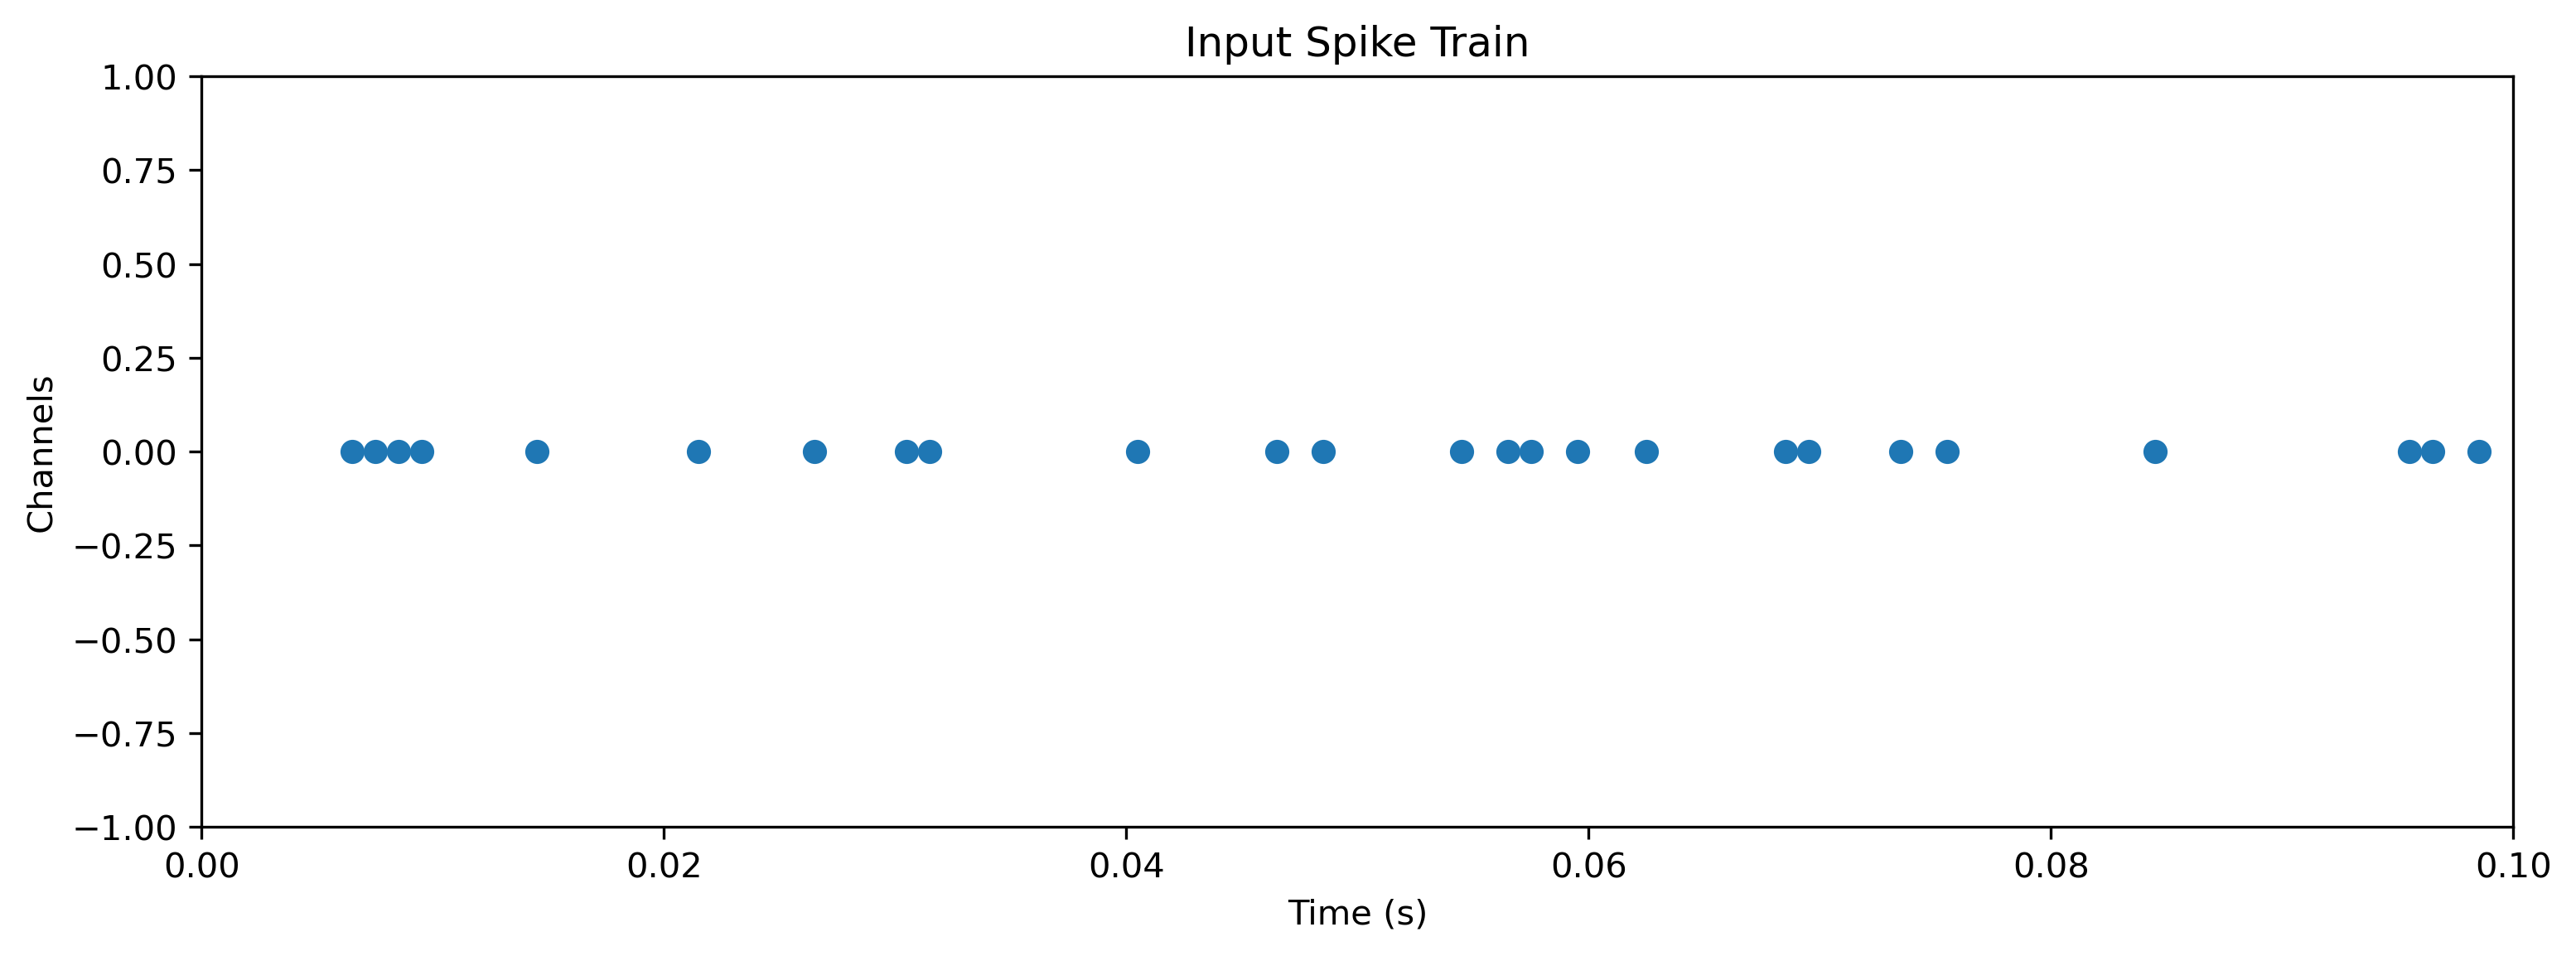

In [11]:
spike_ts = poisson_spike_train(duration=100e-3, rate=200.0, dt=dt, seed=2022)
plot_raster(spike_ts, "Input Spike Train", dt)

Now let's run the model and record the state changes over time

In [12]:
# Run!
model.reset_state()
rate_out, state, record_dict = model(spike_ts, record = True)

In [13]:
# TODO : [OPTIONAL] Explore the output of the model run
# print(rate_out)
# print(state.keys())
# print(record_dict.keys())

### Section 2.2 Observe State Evolution Over Time

At the first stage, input layer makes a linear transformation of the spike train

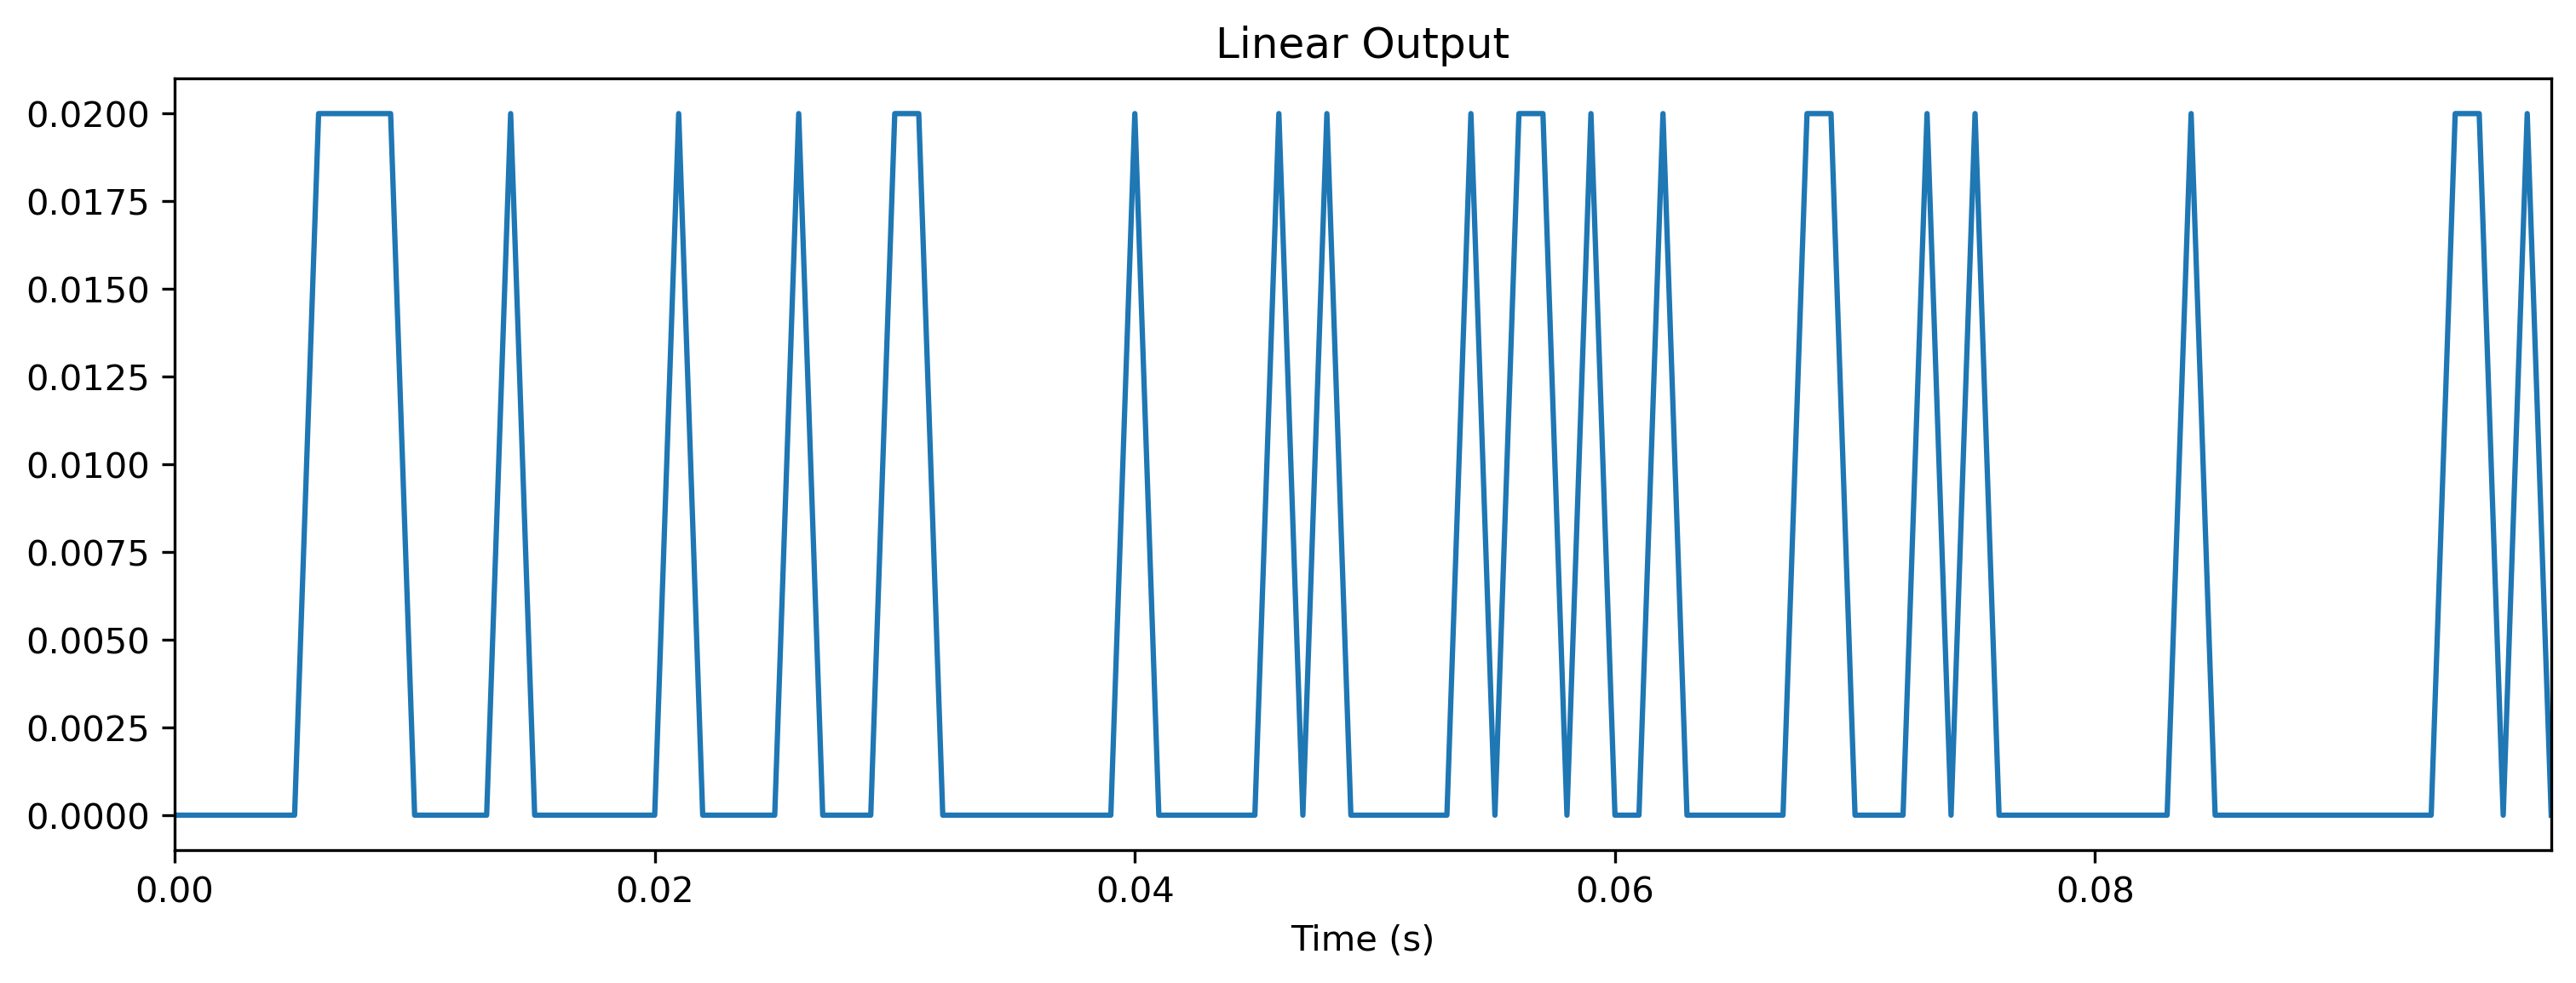

In [14]:
plot_signal(record_dict["0_LinearTorch_output"], "Linear Output", "", dt)

Then second, stateful LIF layer simulates the synapse and neuron membrane dynamics. We can observe
* synaptic current $I_{syn}$ evolution through time
* membrane potential $V_{mem}$ evolution through time
* output spike train

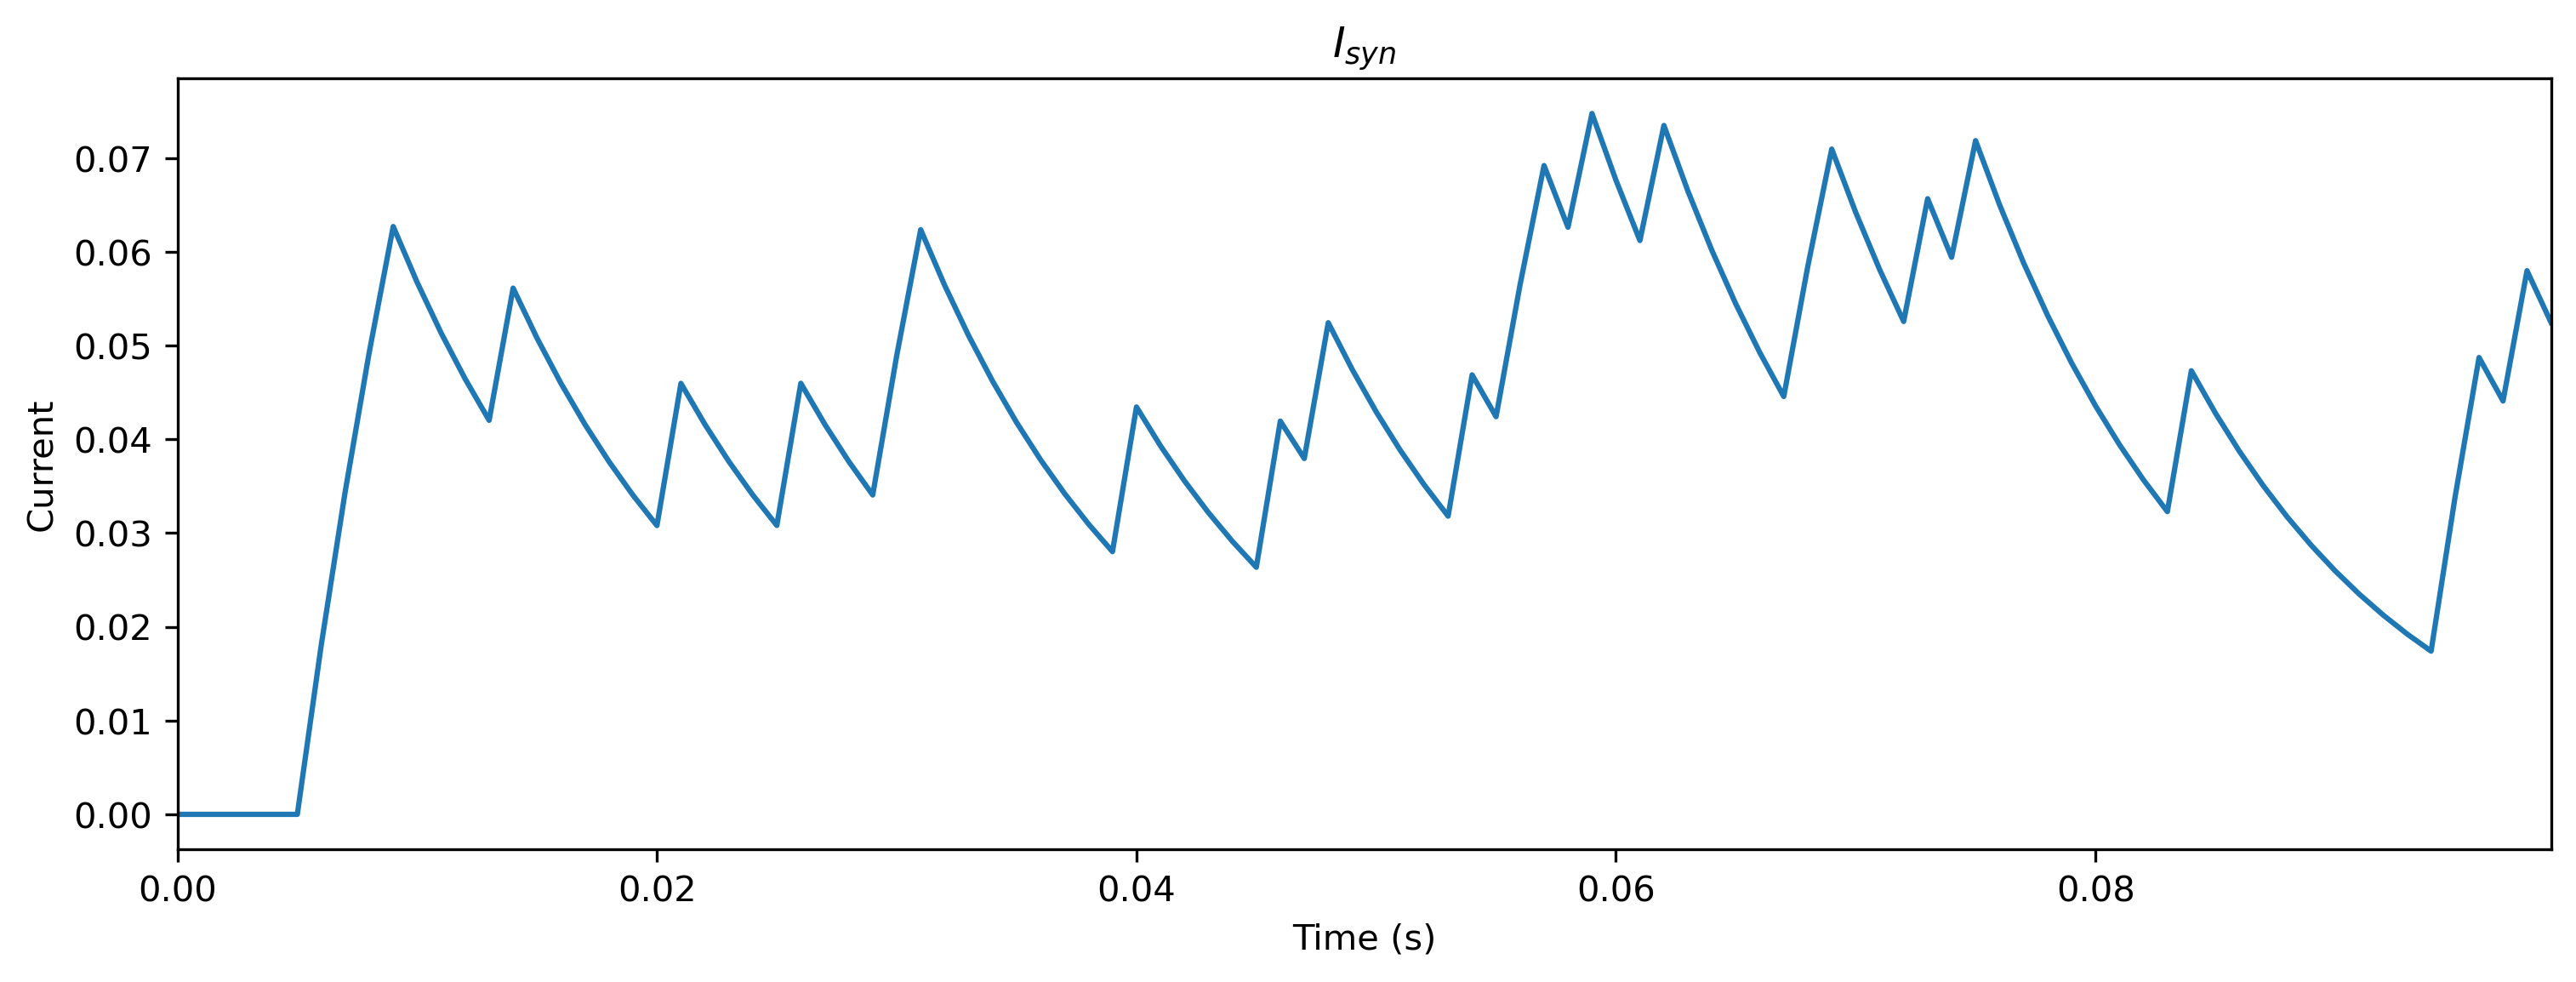

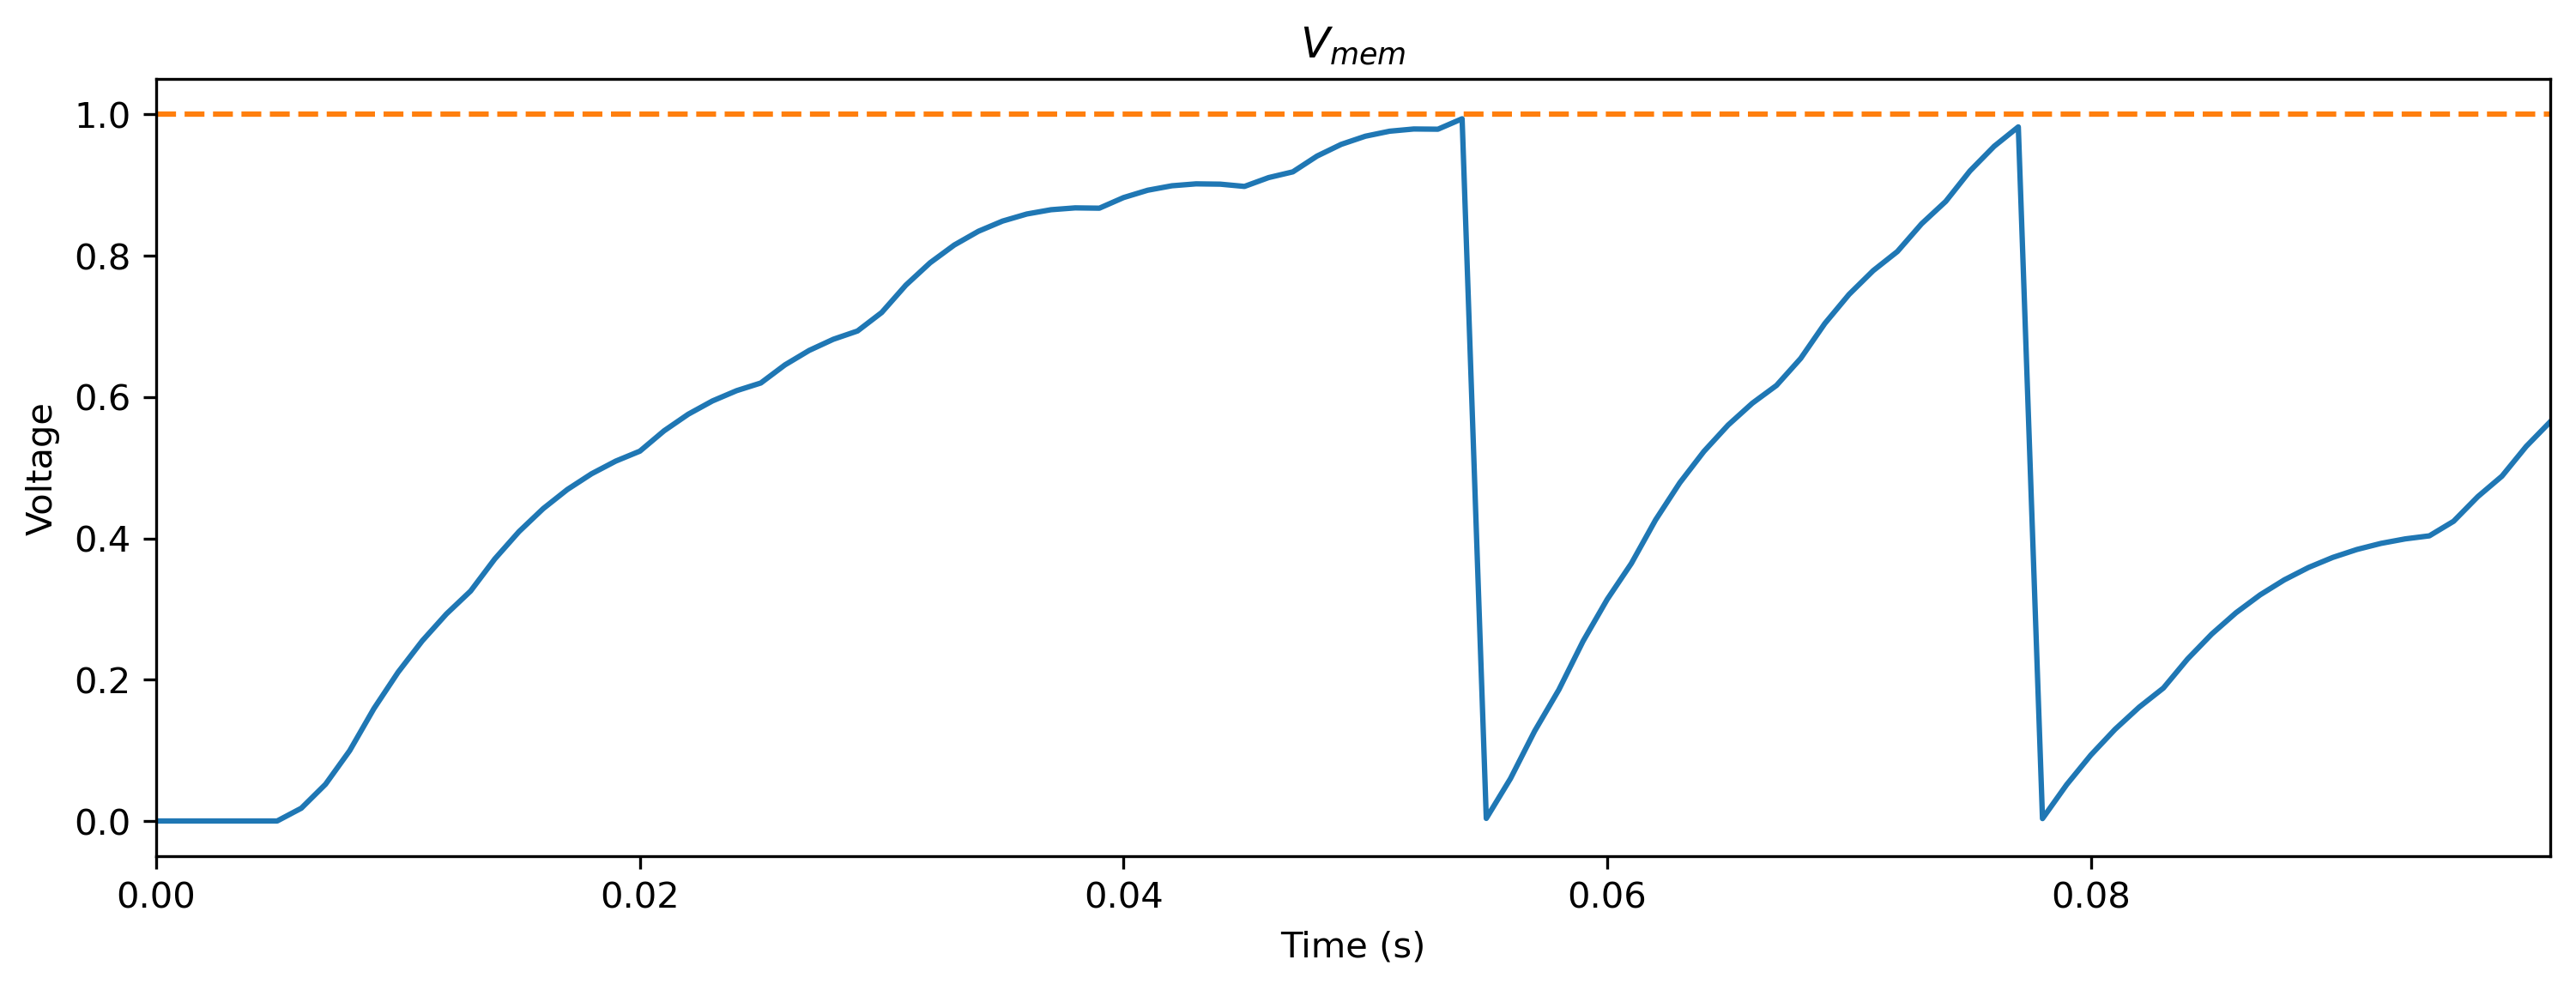

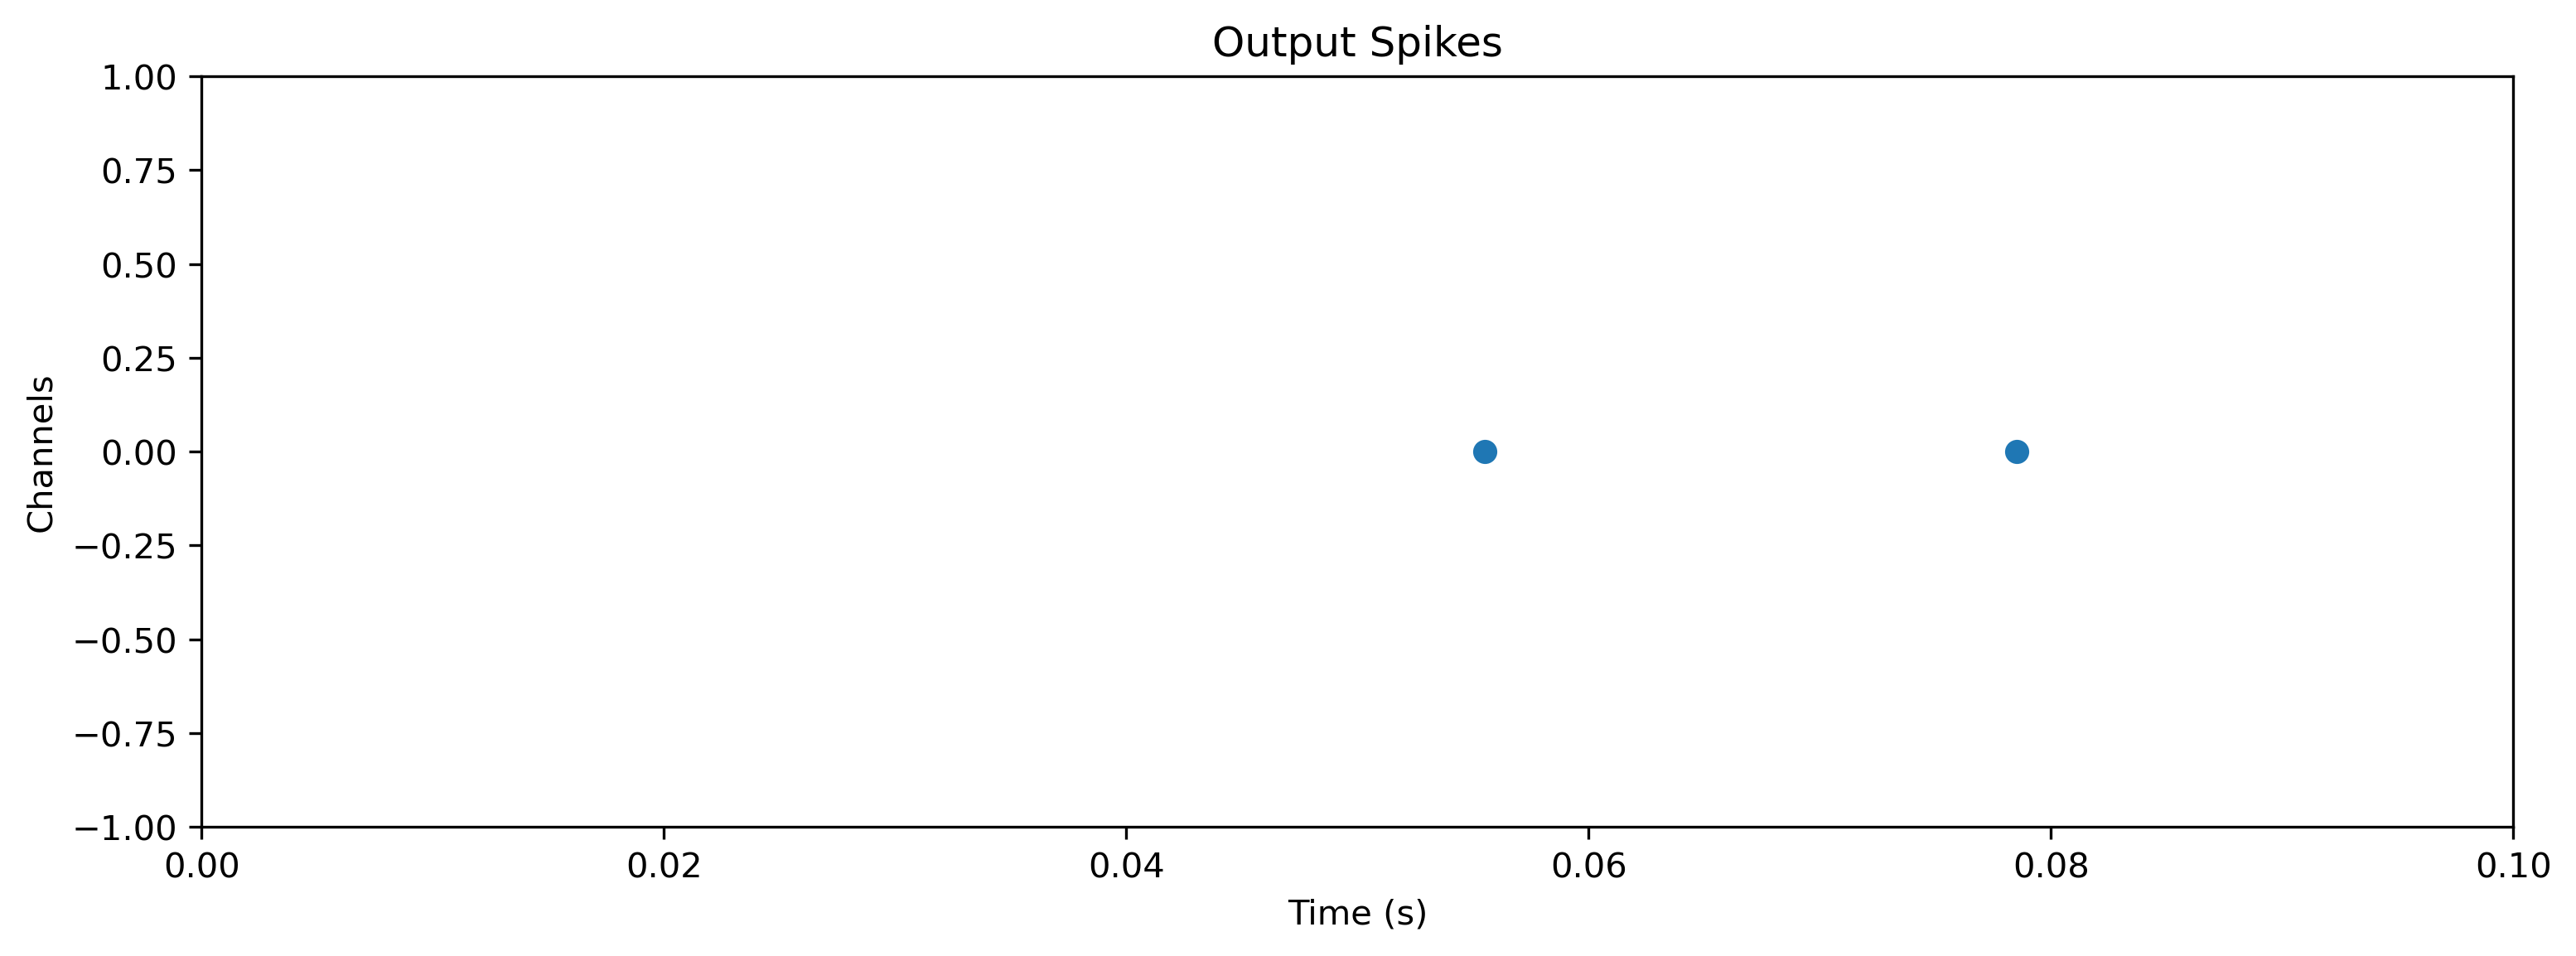

In [15]:
plot_LIF_record(record_dict['1_LIFTorch'], dt=dt, Vth=Vth)

Lastly, the rate readout layer computes the firing rate by counting the number of spikes and dividing them by the time passed. Here 2 spikes produced in 100 ms, and that makes 20 Hz.

In [16]:
print(rate_out)

tensor([[20.]], grad_fn=<DivBackward0>)


---
## Section 3: Define the Optimization Task

The aim is that the network to express a certain firing rate, 50 Hz given the 200 Hz mean firing rate input. In order to achieve this, a target firing rate and a loss function should be defined. 

### Section 3.1 : Target

Here we define the target firing rate.

In [17]:
target = torch.tensor(50.0)

### Section 3.2 : Loss Function

Mean squared error (MSE) is the one of the most commonly used loss function for regression tasks in machine learning. The loss is the mean overseen data of the squared differences between true and predicted values.

MSE Loss : $ l = (r - \hat{r})^ 2 $

Let's investigate the loss function with respect to different rate readings

In [18]:
crit = MSELoss()
loss_trace = []

We can expect that the loss exponentially increases while the output firing rate wanders away from the target rate. However, it's important that since `LIFTorch` actually is a spiking model, the output is actually a number of spikes. We count the number of spikes to read the firing rate, therefore naturally, we would not be able to achieve any firing rate we want. For example, our duration is 100 ms, and with 1 spike produced at that time interval, we can have 10 Hz, with 2 spikes, we can have 20 Hz but we cannot read something like 14.58 Hz.

<img src="figures/ann_snn.png" width="1024">

This problem naturally occurs using spiking neurons. In ANNs, there is no such problem because the input and output signals of the neurons are continuous. In order to see how different it is, let's investigate the loss surface with respect to the weight parameter, which is the only trainable in our task.

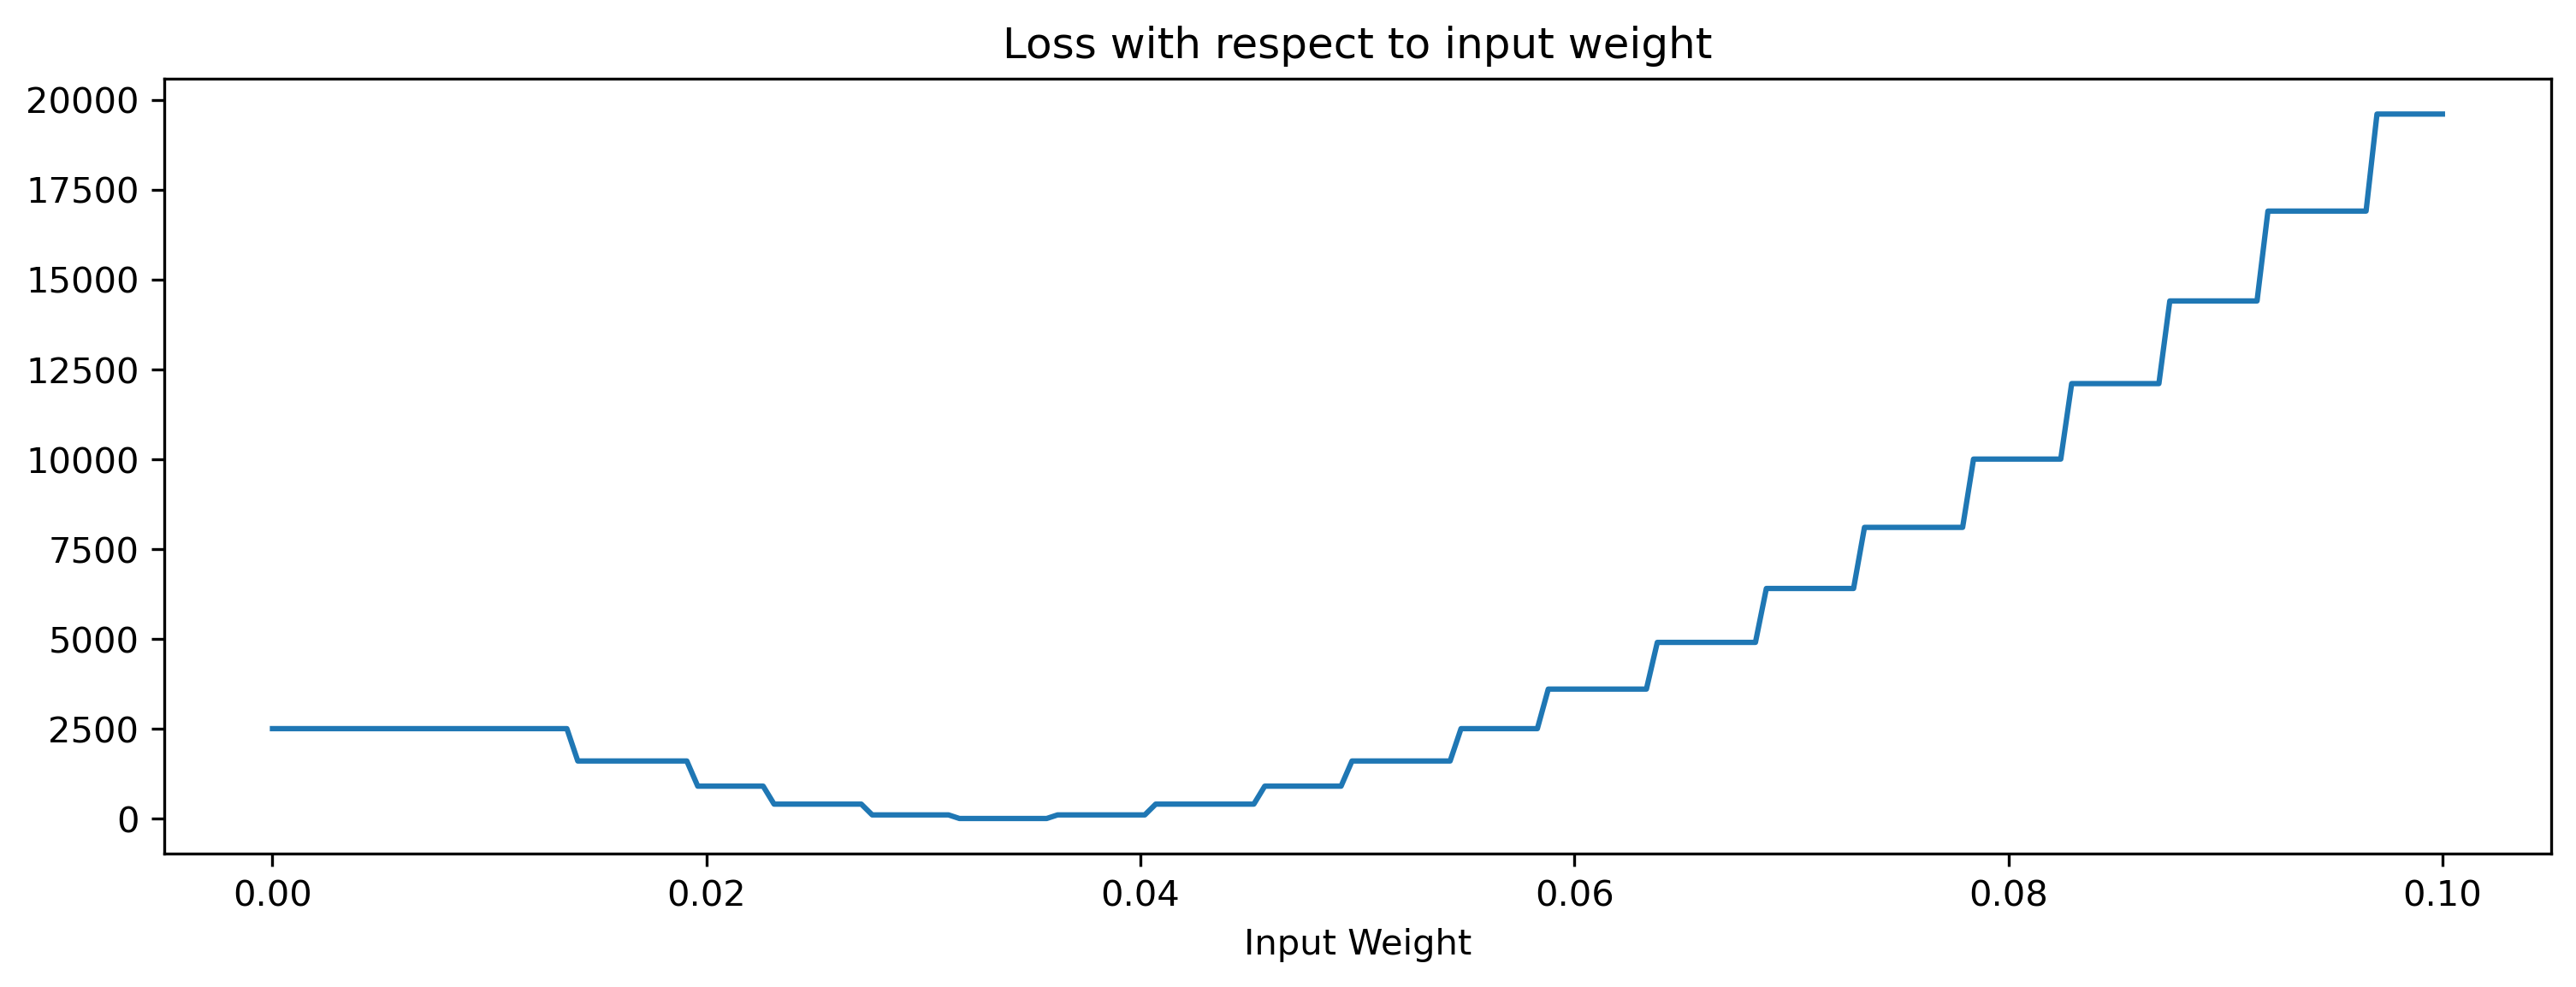

In [19]:
loss_trace = []
grad_trace = []
rate_trace = []

W = np.linspace(0, .1, 200, dtype=np.float32)

# Sweep over the weights
for w in W:
    # Redefine the model with a different input weight
    lin = LinearTorch((1, 1), weight = torch.tensor([[w]]), has_bias=False)
    model = Sequential(lin, lif, readout)

    # Simulate the network exactly with the same input
    model.reset_state()
    out, _, _ = model.evolve(spike_ts, record=True)
    rate_trace.append(out.item())
    
    # Calculate and record the loss
    loss = crit(target, out)
    loss_trace.append(loss.item())

    # Error backpropagation
    # loss -> readout -> lif -> linear         
    loss.backward()    
    grad_trace.append(model[0].weight.grad.item())

# Plot
plt.figure()
plt.plot(W, loss_trace)
plt.title("Loss with respect to input weight")
plt.xlabel("Input Weight");

If we want to apply a gradient based optimization technique to this problem, the process is in general

1. Initialize the weight with a random value
2. Compute the gradient of the loss with respect to weight
3. Slightly move to the opposite direction to the gradient
4. Repeat this until the process converges, and minimum loss achieved

<img src="figures/gradient_descent2.png" width="480">

However, we can see from the loss surface that gradients are 0 almost everywhere. Therefore, we cannot apply a gradient-based optimization procedure to converge into the minimum loss. However, it's not the end of the world! There are several ways to overcome this, we will investigate a popular one: surrogate gradients!

---
## Section 4: Surrogate Gradient Method

*Estimated timing: 10 Minutes*

In surrogate gradient method, the forward pass through a spiking neuron (top) uses a discontinuous spike generation function. The backwards pass (orange) uses a surrogate neuron (bottom, dashed); both neurons share a common weight w. The error x*-y is computed based on the surrogate output, and used to compute an error gradient with respect to the weights, $\nabla w$.

<img src="figures/surrogate_neuron.png" width="640">

*Figure obtained from https://medium.com/neuromorphic-intelligence/putting-the-neural-back-into-networks-7a70bd267610*
 

### Section 4.1: LIFTorch Forward Pass

In `LIFTorch` neuron, if the membrane potential $V_{mem}$ is above a threshold $V_{th}$, the neuron produces a spike event on the output. It uses a Heaviside function in the forward pass.

$y = H(V_{mem}, V_{th}) = V_{mem} > V_{th}$

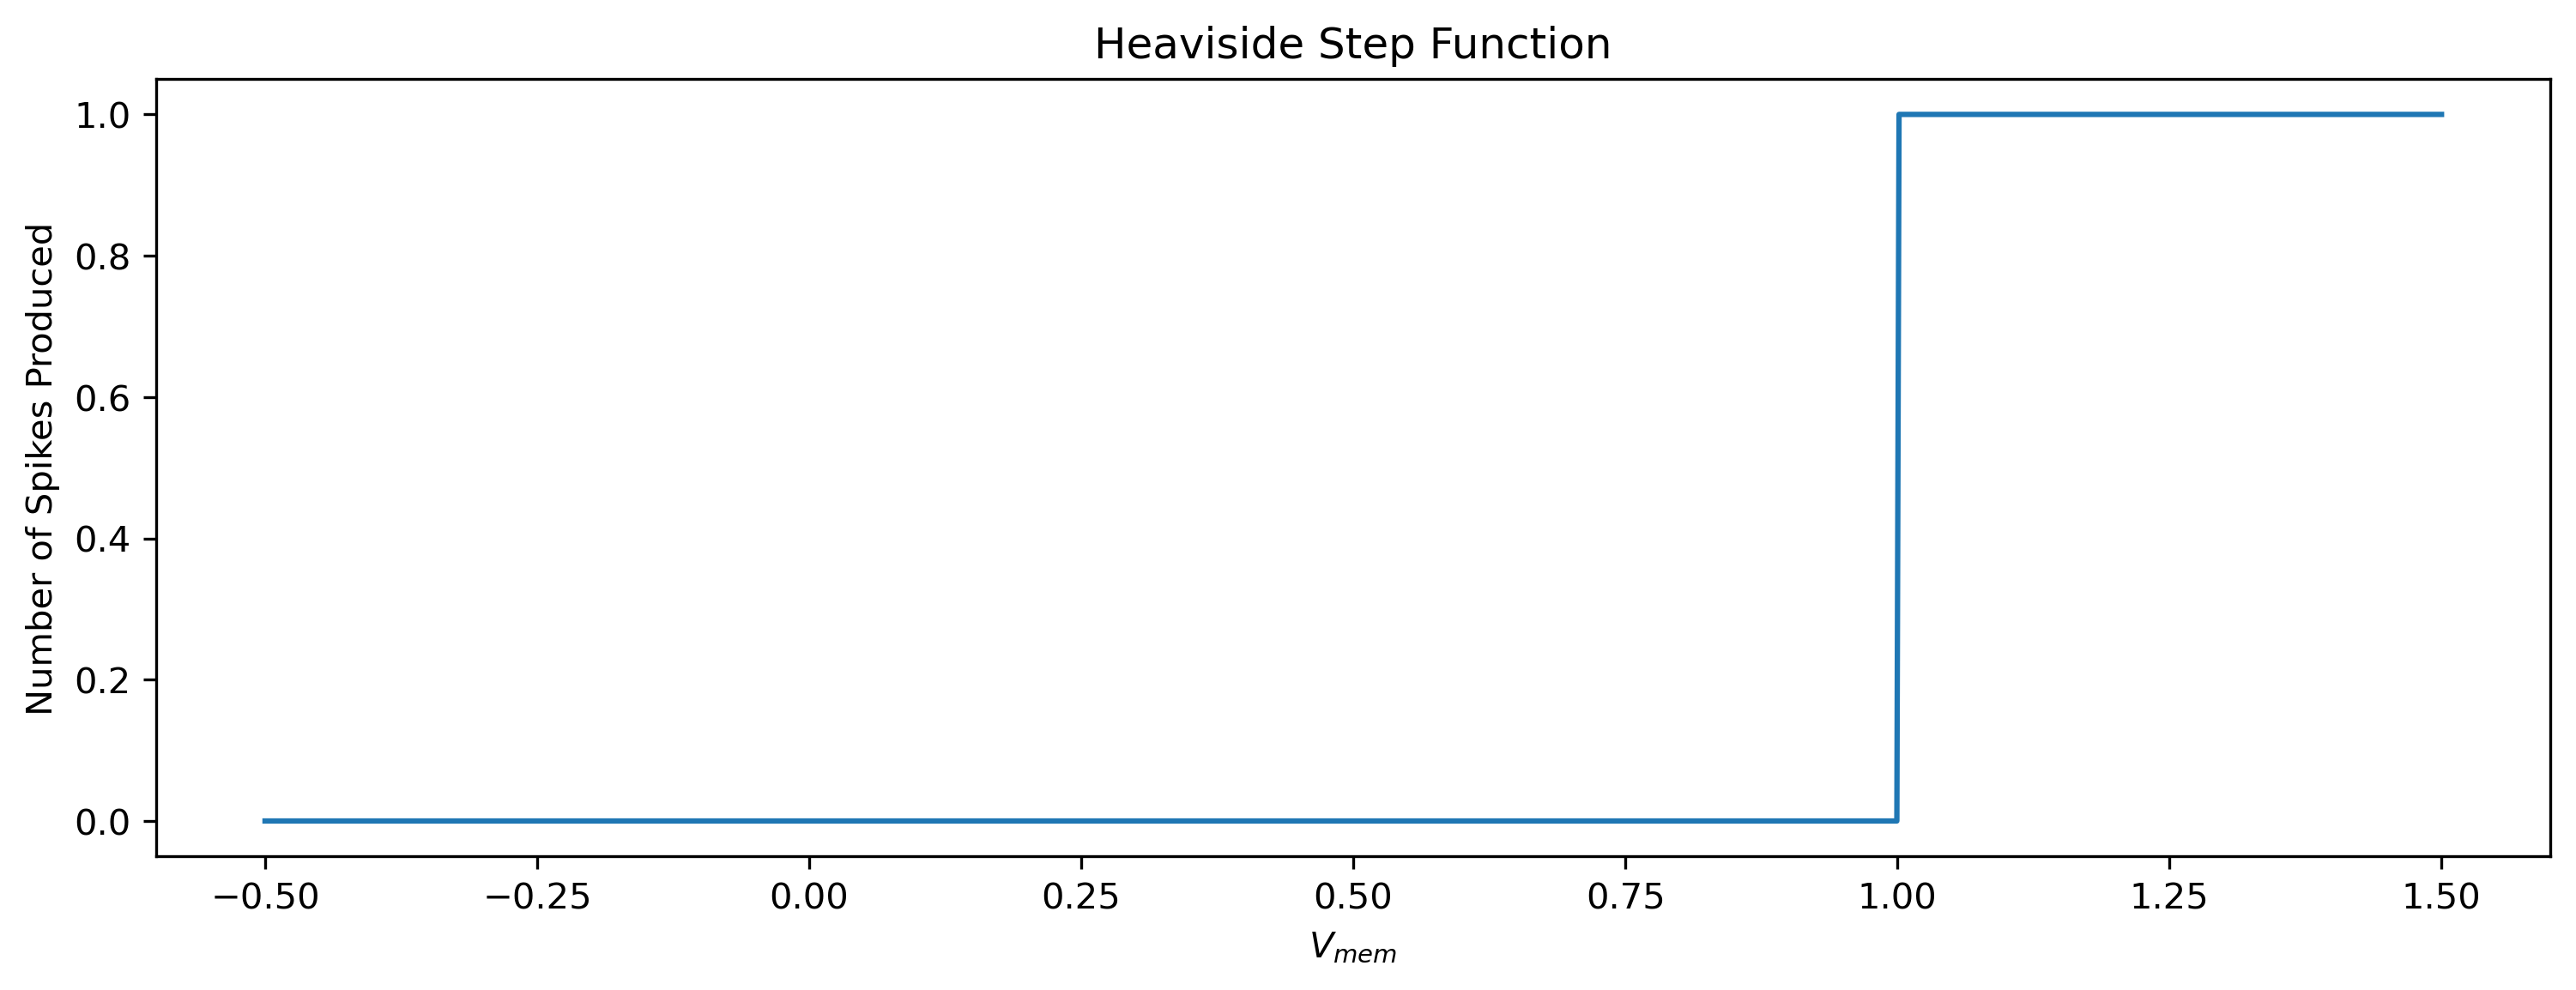

In [20]:
x = torch.linspace(-0.5, 1.5, 1000, requires_grad=True)

# Function
step_pwl = StepPWL.apply
y = step_pwl(x, torch.tensor(1.0), torch.tensor(1.0), torch.tensor(float("inf")))

# Plot
plt.figure()
plt.plot(x.detach(), y.detach())
plt.title("Heaviside Step Function")
plt.xlabel("$V_{mem}$")
plt.ylabel("Number of Spikes Produced");

### Section 4.2 LIFTorch Backward Pass

If we compute the gradient of y with respect to x, we would see something different than the gradient of the heaviside step function, that is the gradient of the surrogate neuron's transfer function

In [21]:
# [IMPORTANT] Run this line just once!
y.backward(x)

In order to observe the surrogate neuron's transfer function, we can integrate the gradient calculated.

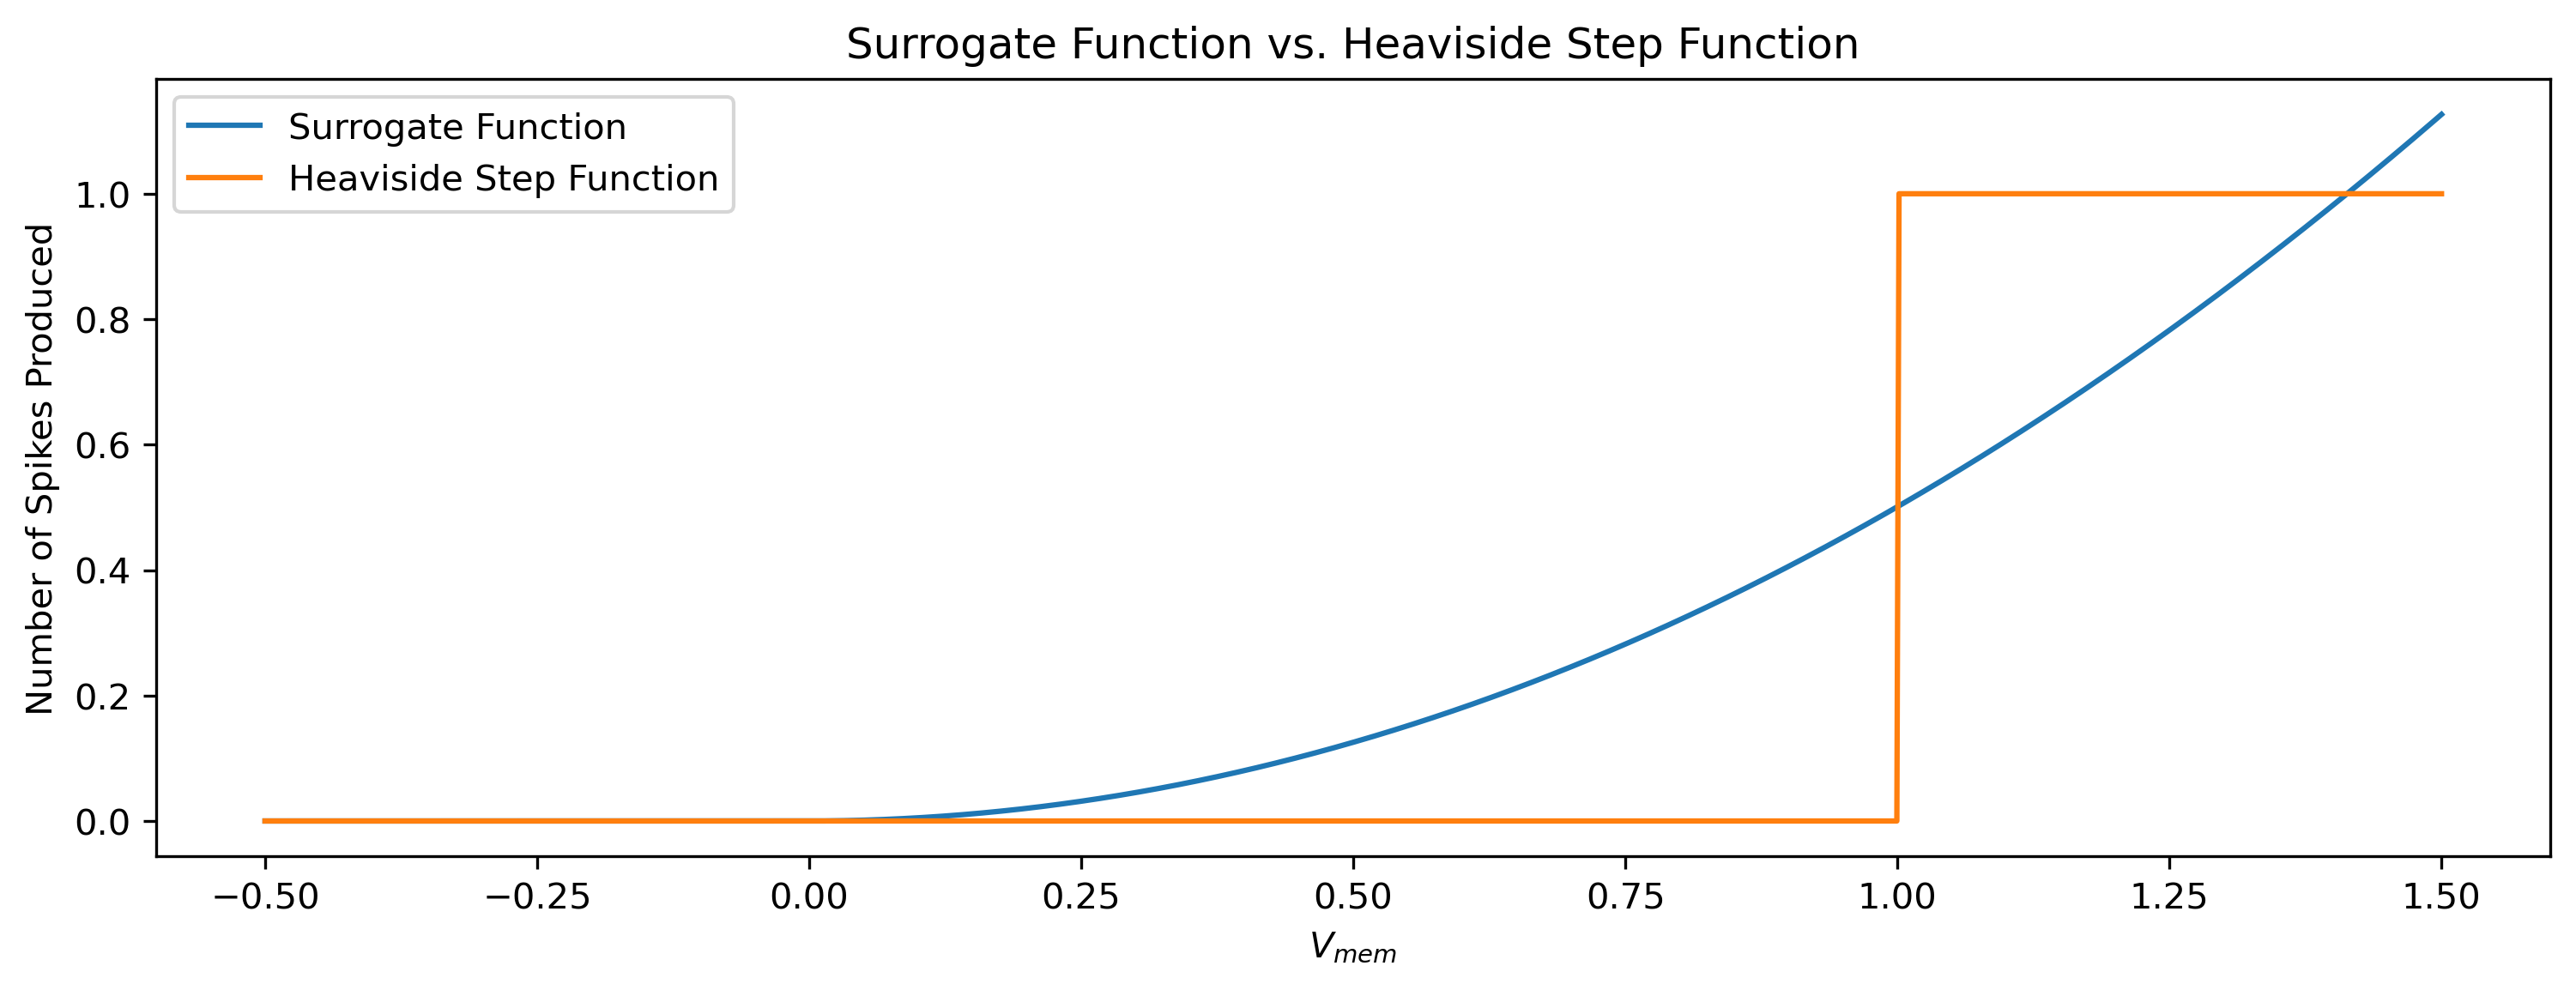

In [22]:
surrogate = np.cumsum(x.grad.detach().flatten()*(x[1]-x[0]).detach().item())
plt.plot(x.detach(), surrogate, label = "Surrogate Function")
plt.plot(x.detach(), y.detach(), label = "Heaviside Step Function")
plt.title("Surrogate Function vs. Heaviside Step Function")
plt.legend();
plt.xlabel("$V_{mem}$")
plt.ylabel("Number of Spikes Produced");

Here we can see the gradient of the surrogate transfer function.

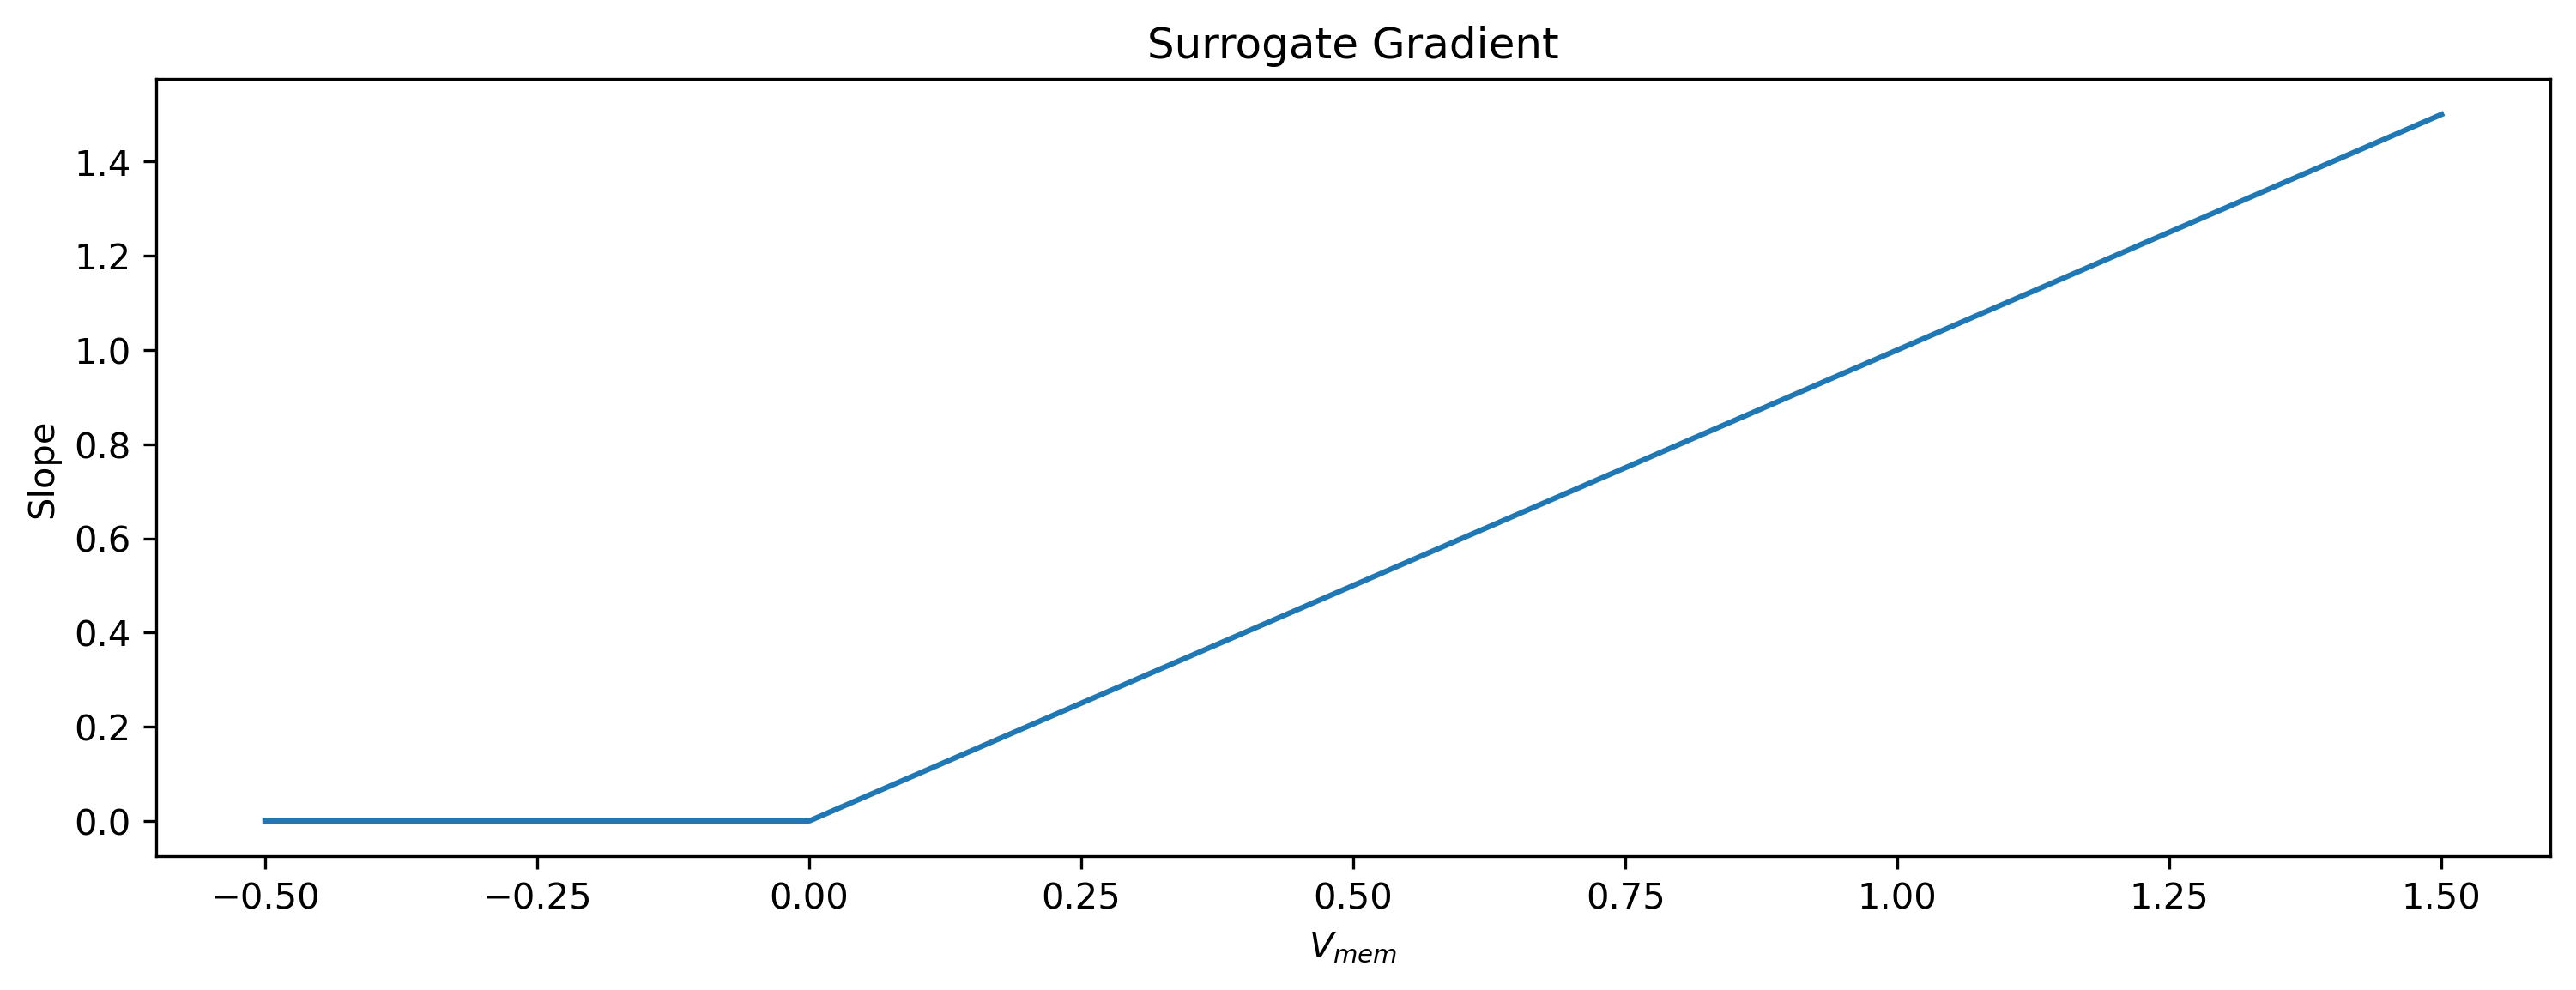

In [23]:
plt.figure()
plt.plot(x.detach(), x.grad.detach())
plt.title("Surrogate Gradient");
plt.xlabel("$V_{mem}$")
plt.ylabel("Slope");

### Section 4.3 : Approximate Loss Surface

If we look at the loss surface calculated using the surrogate gradient approach, we see that it's differentiable! It allows us to apply gradient-based optimization to the problem and converge to the minimum loss.

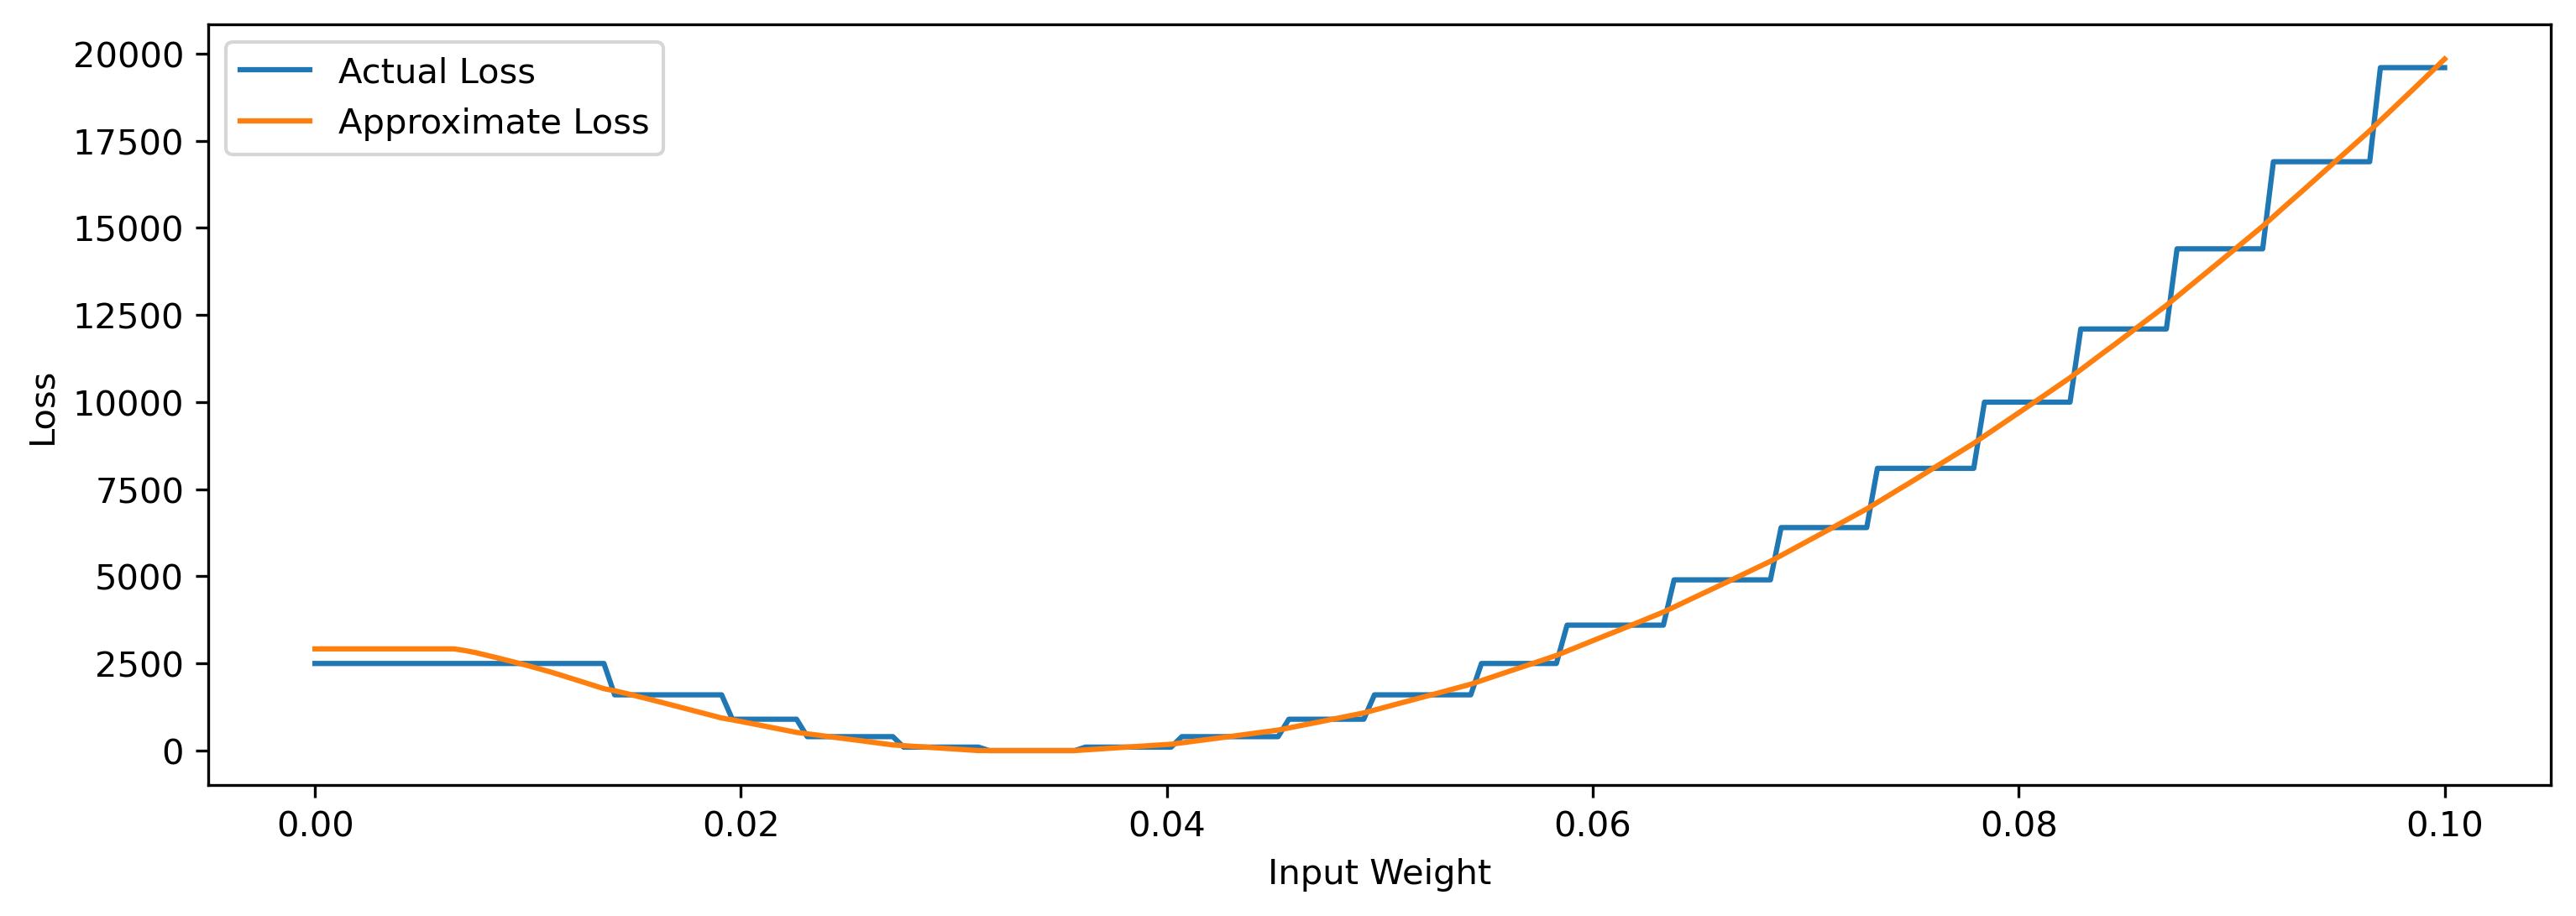

In [24]:
surrogate_loss = np.cumsum(np.array(grad_trace).flatten()*(W[1]-W[0]))
surrogate_loss = surrogate_loss - np.min(surrogate_loss) + np.min(loss_trace)

plt.figure()
plt.plot(W, loss_trace, label = "Actual Loss")
plt.plot(W, surrogate_loss, label = "Approximate Loss")
plt.xlabel("Input Weight")
plt.ylabel("Loss")
plt.legend();


## Section 5 : Training a Spiking Neural Network

So far we have explored spiking rockpool modules and now we're ready to optimize our network. Let's first re-initialize the linear layer.

In [25]:
# Reinitialize the weight matrix

# TODO : Change the weight to see what happens
# TODO : What happens if we initialize the input weights very close to 0?

# --- Input Layer --- #
linear = LinearTorch(
    shape=(1, 1),
    weight=torch.tensor([[1.2]]),
    has_bias=False,
)

# --- Model --- #
model = Sequential(linear, lif, readout)
model

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

### Section 5.1 : Training Loop

We are using the MSE loss and Adam, a popular stochastic gradient descent like optimization algorithm, during training. The whole workflow is very similar to the native `torch` API.

In [26]:
# Configure the optimization
epochs = 1000
learning_rate = 1e-2

# Construct the optimizer
optim = Adam(model.parameters().astorch(), lr=learning_rate)

# Record the loss and parameters changes
param_trace = []
loss_trace = []

for i in tqdm(range(epochs)):

    # Reset the state variables: Vmem, Isyn, spikes
    model.reset_state()

    # Reset the optimizer
    optim.zero_grad()

    # Run model
    out, state, rec = model(spike_ts, record=True)

    # Calculate the MSE loss between expected rate and the target
    loss = crit(target, out)
    loss_trace.append(loss.item())

    # Early stopping criteria
    if loss == 0:
        break

    # Error backpropagation : readout -> LIF -> input
    loss.backward()

    # Update the network parameters
    optim.step()

    # Record the parameter change
    param_trace.append(model[0].weight.data.item())

 30%|███       | 305/1000 [00:15<00:35, 19.82it/s]


### Section 5.2 : Results

Let's check what happened during after training. First we can see that loss converges to zero. It means that we get exactly what we want!

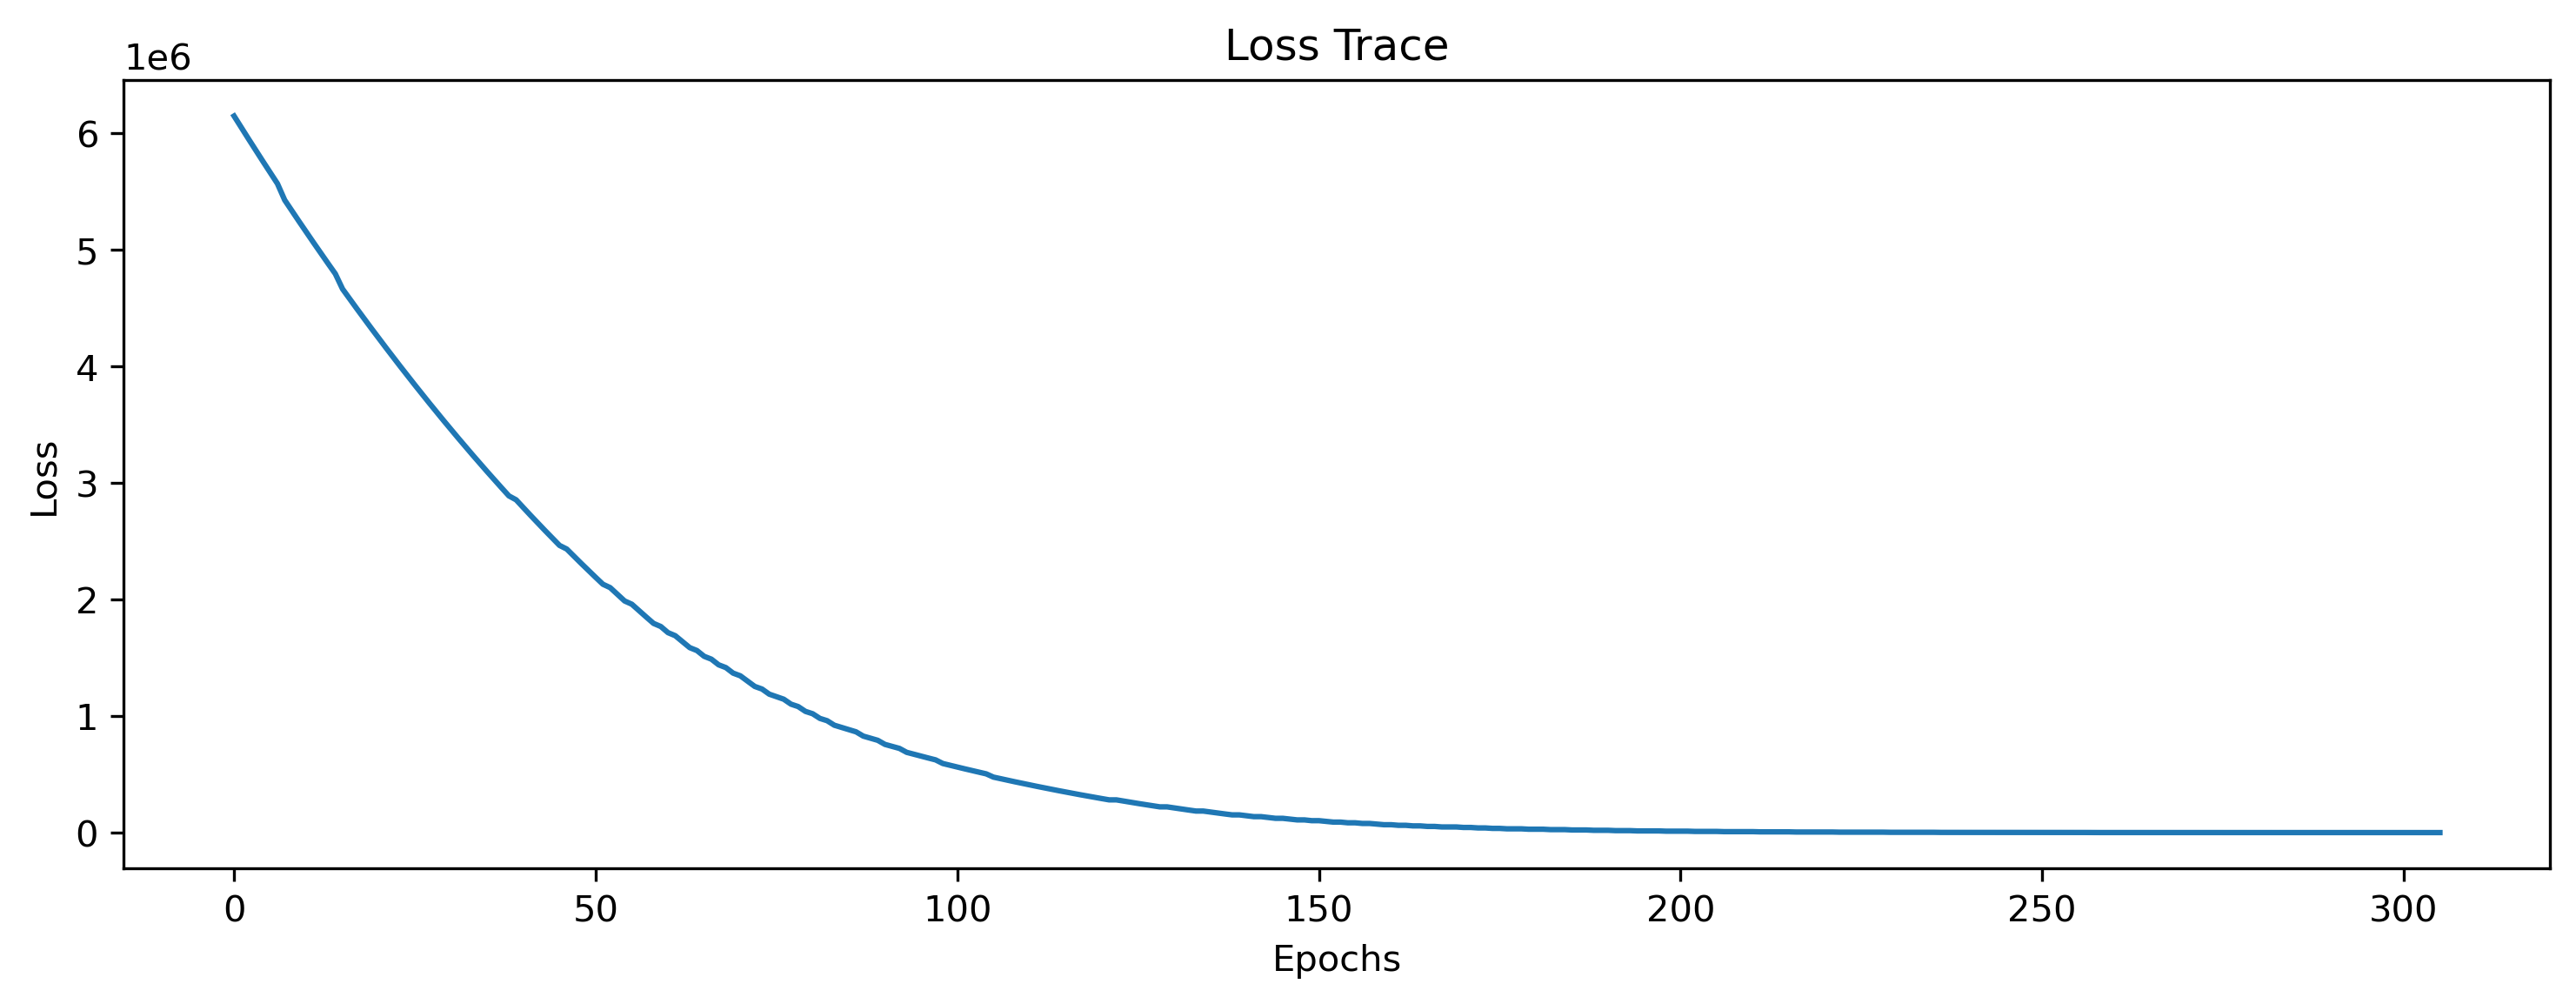

In [27]:
plt.plot(loss_trace)
plt.title("Loss Trace")
plt.xlabel("Epochs")
plt.ylabel("Loss");

How this has happend? Inside the training loop, Adam continuously updated the weight parameter towards the direction of minimum loss.

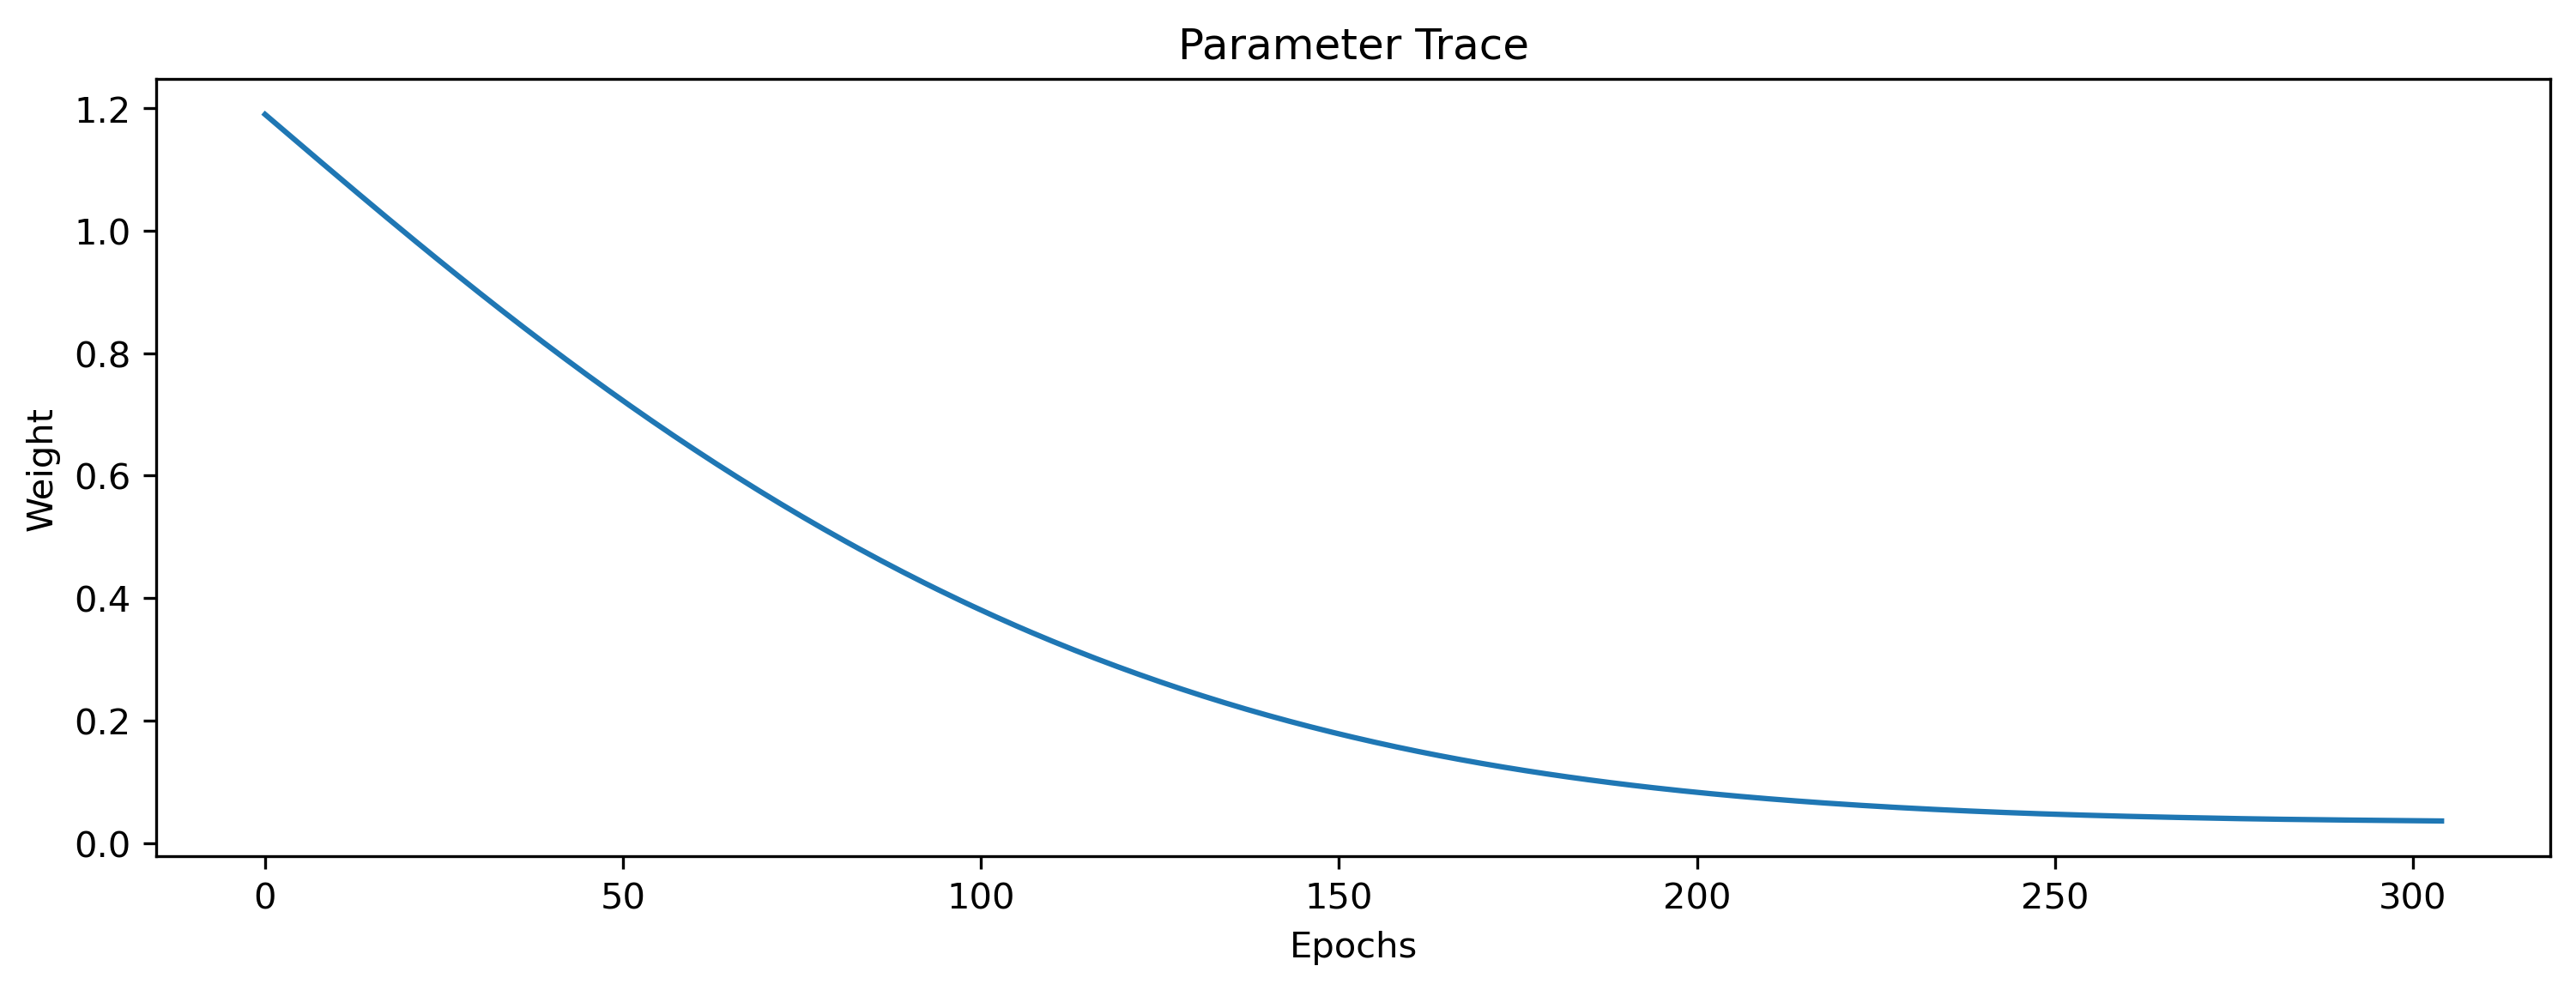

In [28]:
plt.plot(param_trace)
plt.title("Parameter Trace")
plt.xlabel("Epochs")
plt.ylabel("Weight");

Finally, run the optimized module and prove that it expresses a spike firing rate of 50 Hz.

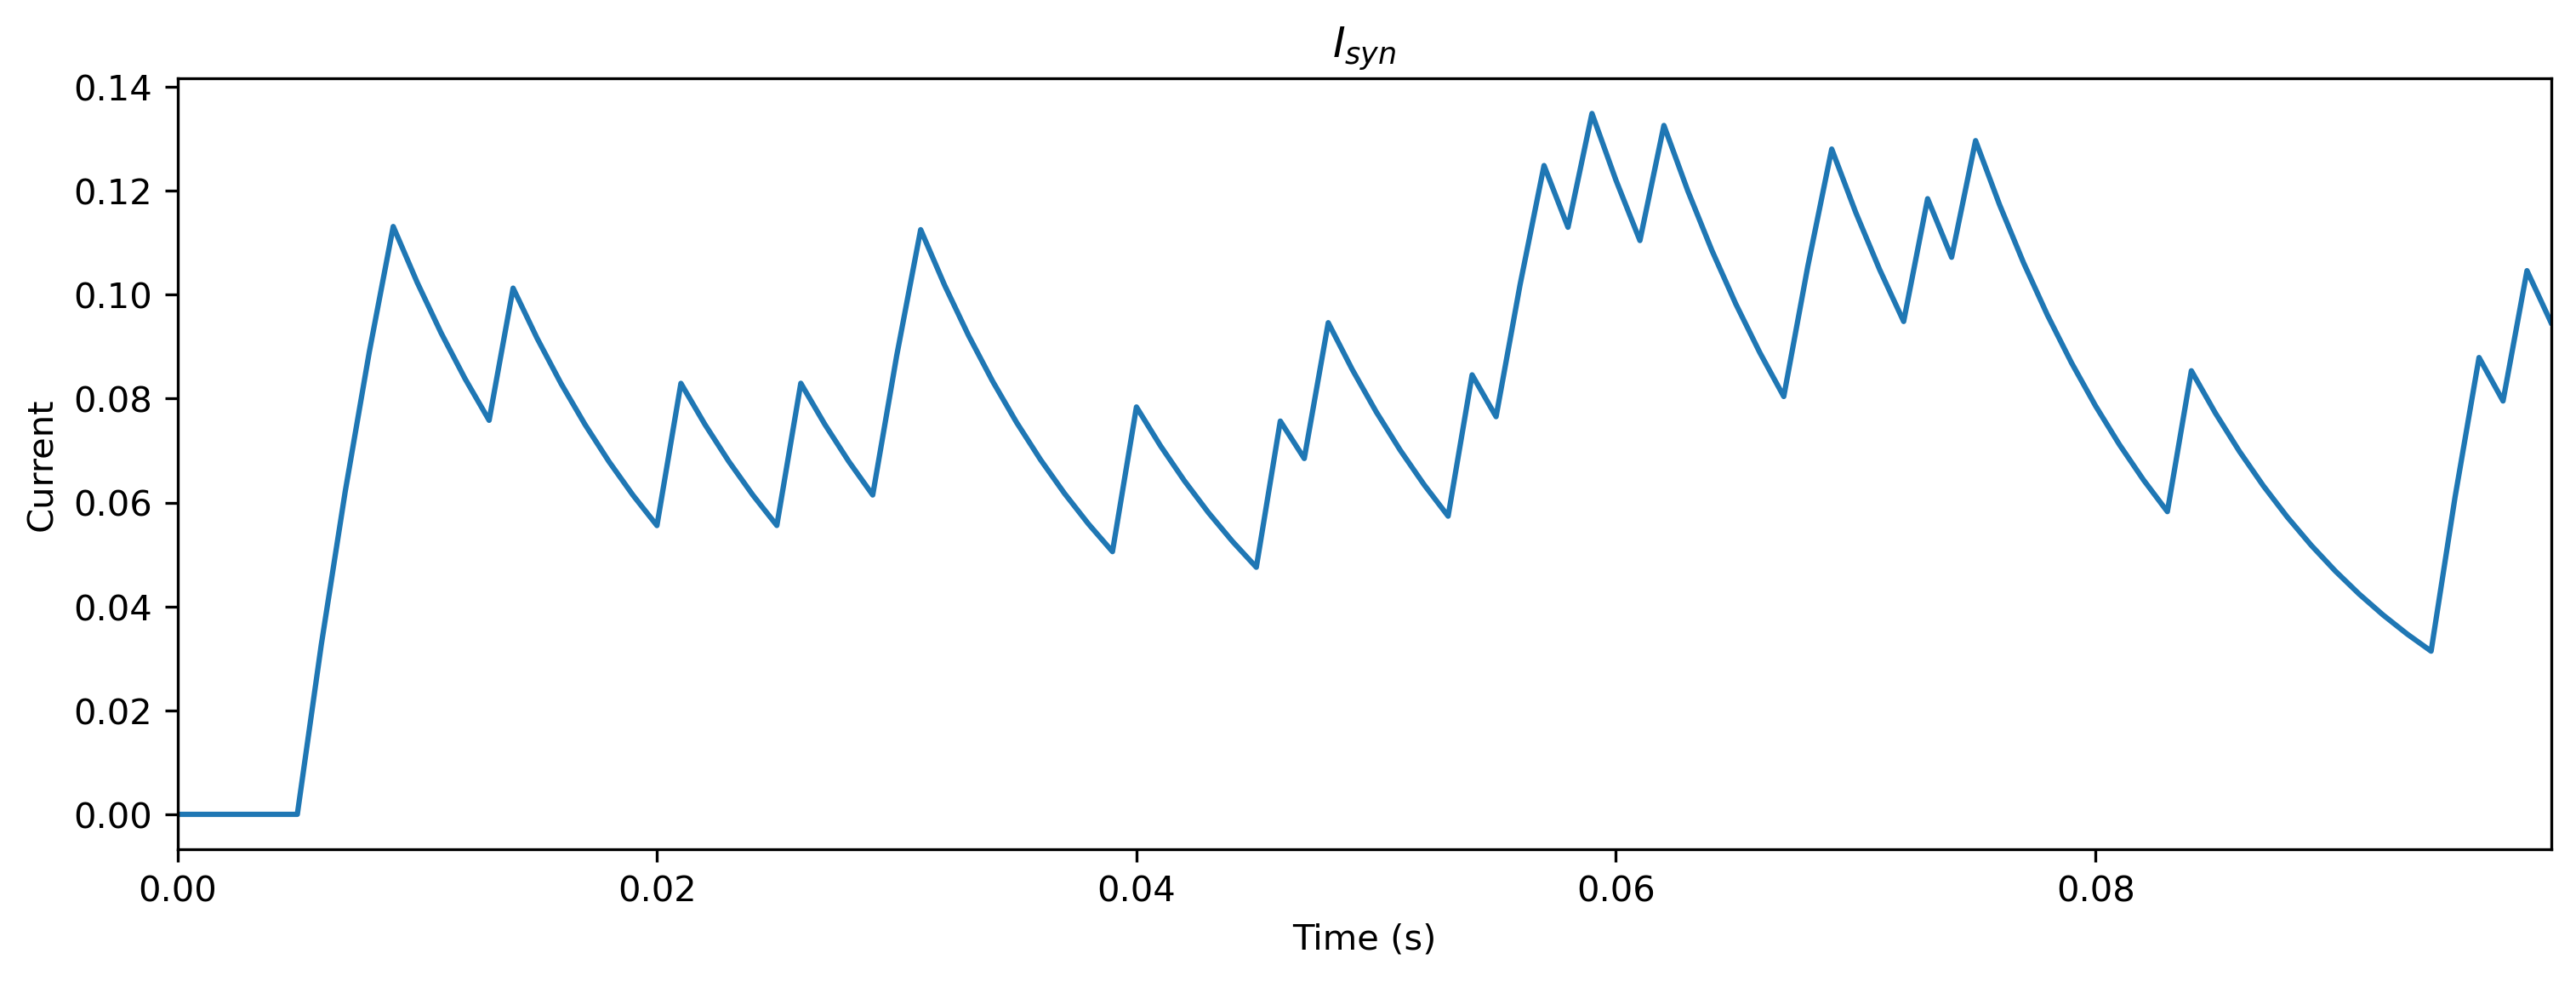

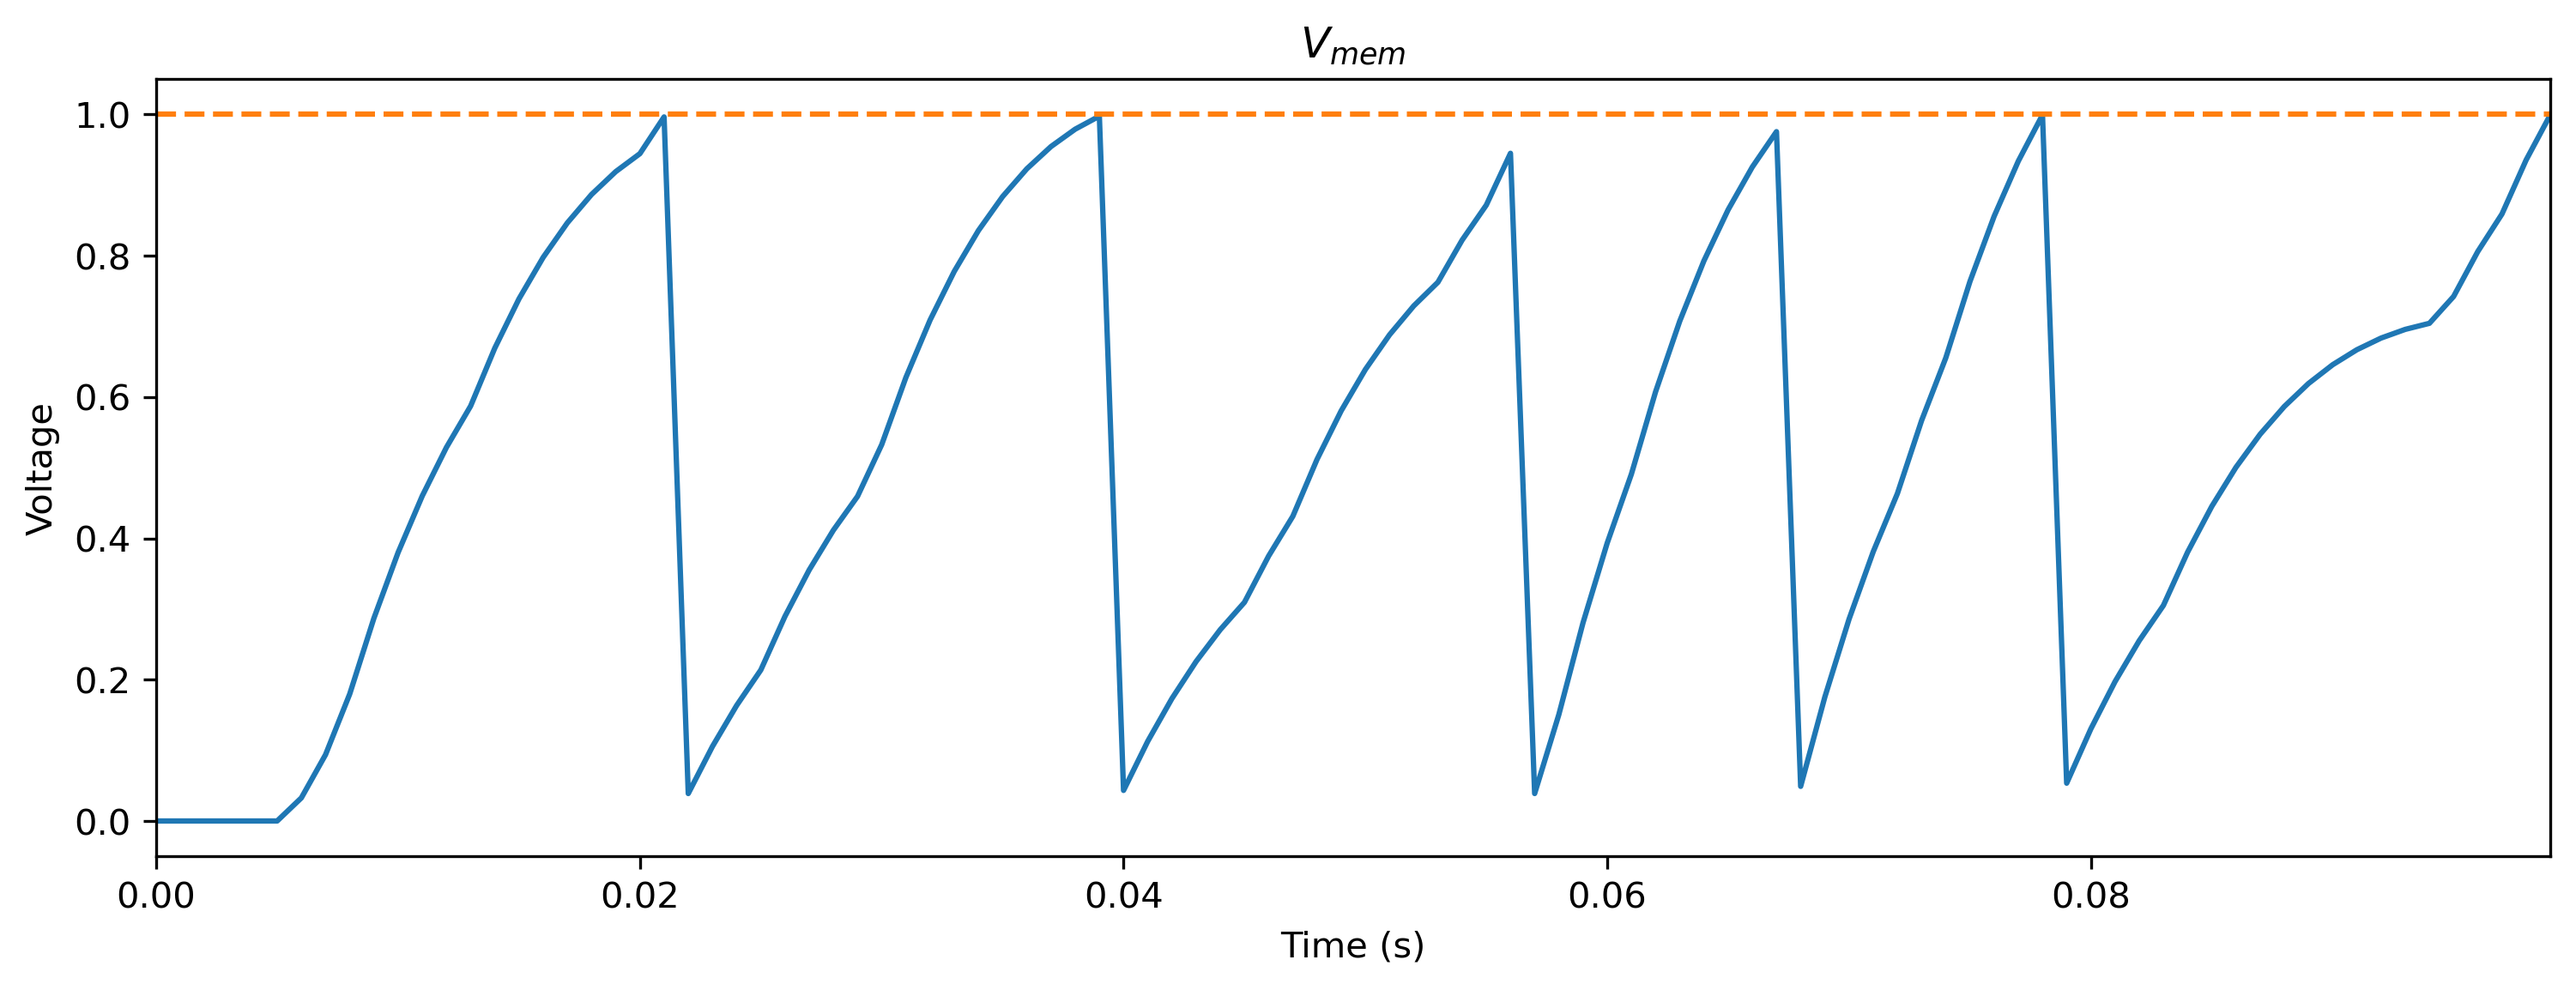

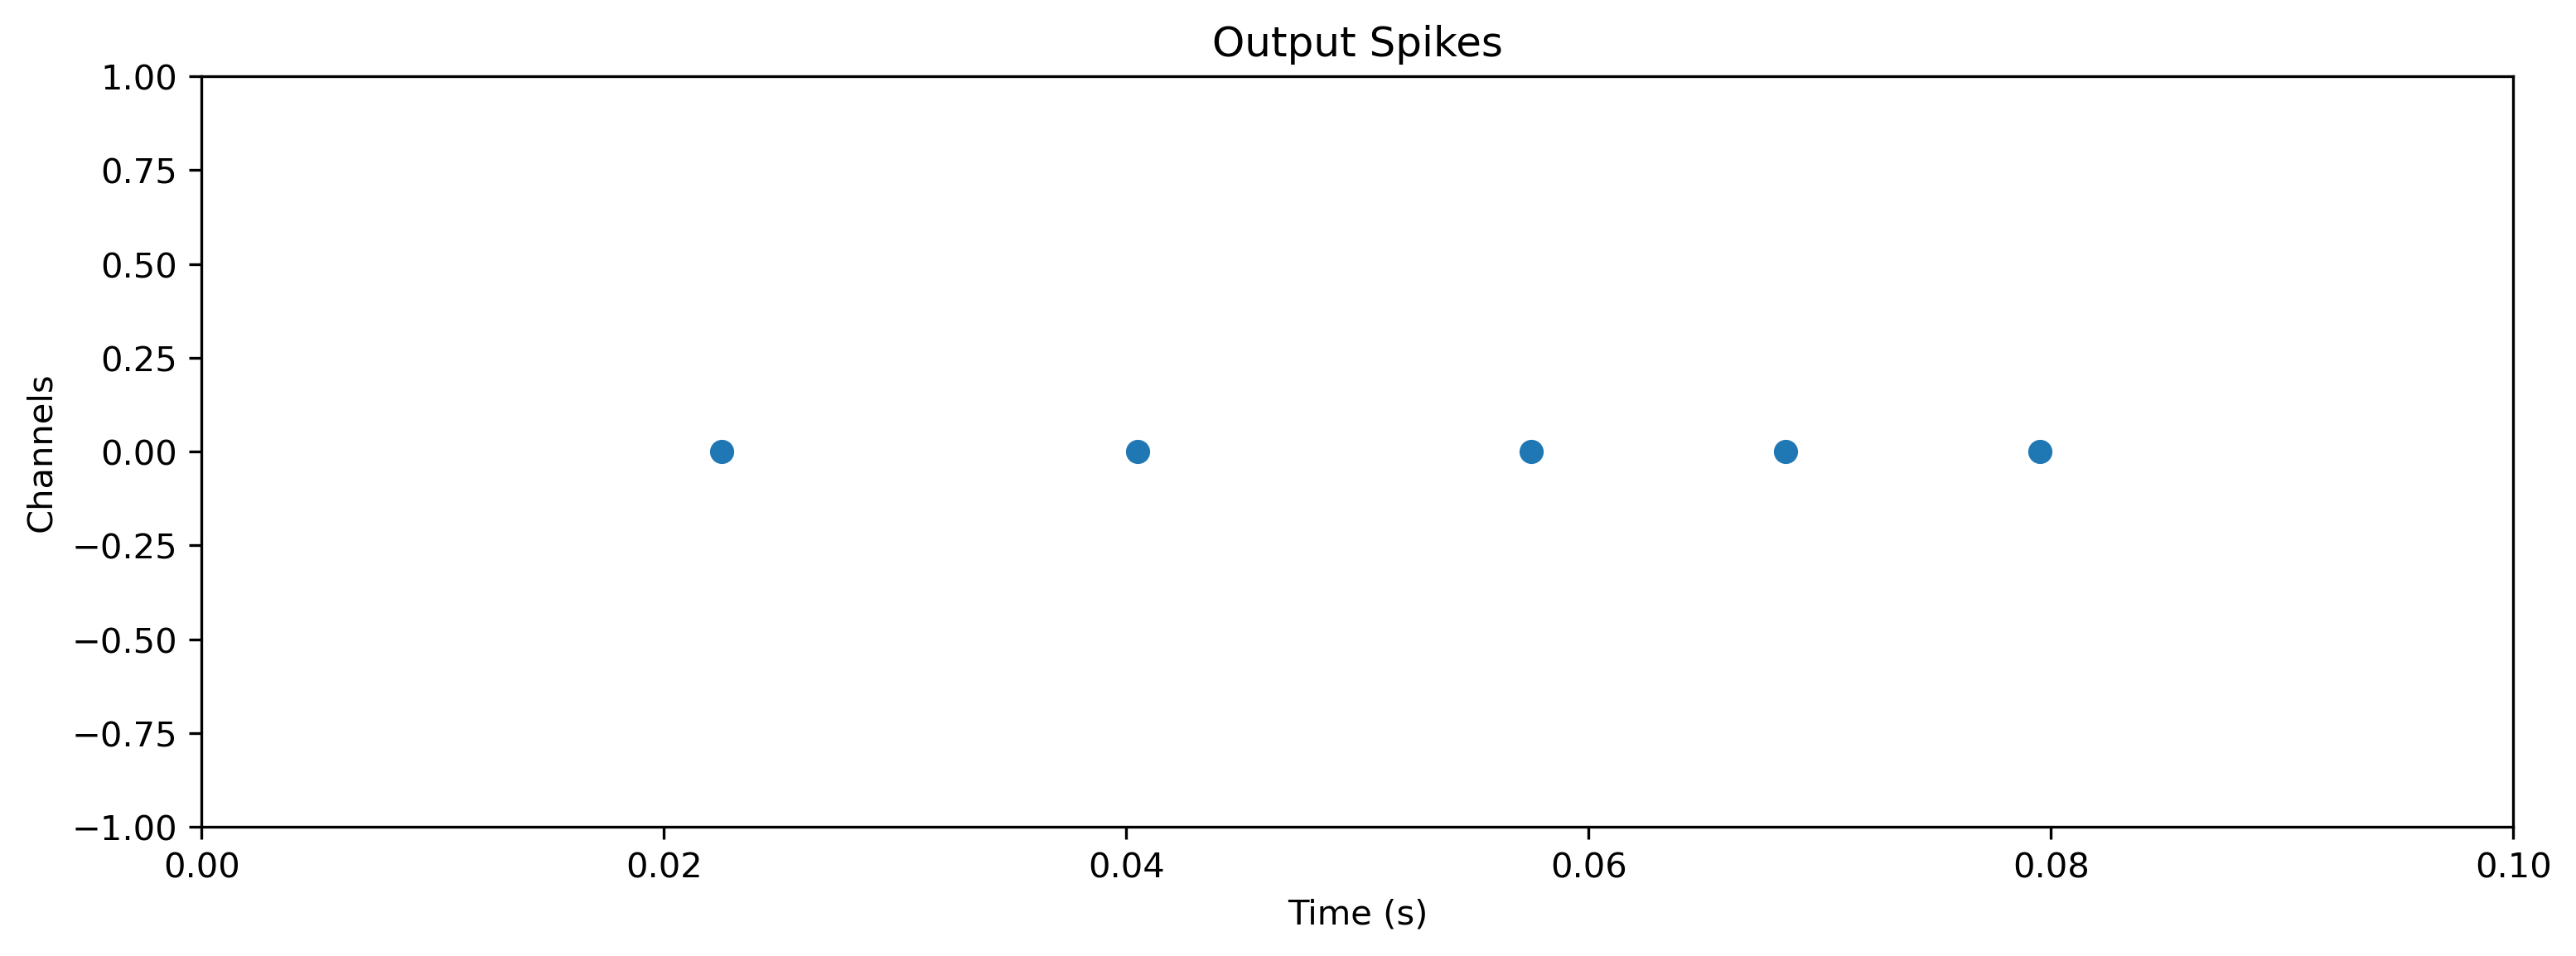

In [29]:
model.reset_state()
out, state, rec = model(spike_ts, record=True)
plot_LIF_record(rec['1_LIFTorch'], dt=dt, Vth=Vth)

See that the rate reading is 50. That concludes our tutorial!

In [30]:
out.item()

50.0

# Conclusion

In this tutorial, we have optimized a one-channel one-neuron spiking neuron to fire at a certain rate given a poisson spike train with a certain mean frequency. We have explored the behavior of a torch-end Rockpool spiking module `LIFTorch`. We have investigated the reason behind using surrogate gradients to apply gradient-based optimization in training spiking neural networks. We have seen that it works well! Now, next step is to use these techniques to accomplish complex task. Stay tuned! 
